# Introduction & Problem Statement

The Ames Housing Dataset contains information from the Ames Assessor’s Office used in computing assessed values for individual residential properties sold in Ames, IA from 2006 to 2010. The dataset consists of over 2000 observations of over 80 features relating to the properties of the house. 

The target variable we are interested in predicting is the sale price of the house. Predicting the sale price of the house can be very complicated because of the many factors affecting it. Home-owners & prospective home-buyers would be very interested in accurate predictions in order to get the best value for their money.

The problem we are trying to solve here is: **How can we best predict the sale price of a house using a linear regression model?**

In this project, we will construct a multiple linear regression model that will take in several independent variables and predict the sale price of a house. There is a training set with the target variable as well as a test set without the target variable. Our goal is to best predict the sale prices of the houses in the test set, and our predictions will then be evaluated on Kaggle.


## Contents:
- [Data Cleaning & Feature Engineering](#Data-Cleaning-&-Feature-Engineering)
- [EDA](#EDA)
- [Preprocessing](#Preprocessing)
- [Exporting Cleaned Datasets](#Exporting-Cleaned-Datasets)

In [1]:
# Necessary Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

%matplotlib inline

In [2]:
full_train = pd.read_csv('../datasets/full_train.csv')

In [3]:
# Renaming columns for ease of reference
full_train.columns = [x.lower().replace(' ', '_').replace('/', '_') for x in full_train.columns]

In [4]:
# Enabling Jupyter Notebook to display all columns for ease of data cleaning later on
pd.set_option('display.max_columns', None)

Our training set will be further split into a partial training set and validation set. This is to ensure that our model does not 'see' the data in the validation set. We will be conducting all our analysis on the partial training set, then evaluating our model on the validation set. 

In [5]:
# Splitting into training set and validation set
train, validation = train_test_split(full_train, test_size=0.2, random_state=0)

In [6]:
# Resetting index for shuffled training & validation sets
# Reassigning instead of inplace parameter used to avoid SettingWithCopy warning
train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)

In [7]:
# Exporting training & validation set to .csv files
train.to_csv('../datasets/partial_train.csv', index=False)
validation.to_csv('../datasets/validation.csv', index=False)

# Data Cleaning & Feature Engineering

## Preliminary Elimination of Features

Some features can be immediately dropped as they are unique to each observation and have no relation to the properties of the house whatsoever.

In [8]:
train.drop(columns=['id', 'pid'], inplace=True)

We will also begin by checking for duplicate rows or columns.

In [9]:
# Verifying there are no duplicate rows
train.duplicated().sum()

0

In [10]:
# Finding duplicate columns
# Inspect data dictionary, see possible columns which might be duplicates
# columns which describe quality and condition: have identical categories
# overall, exter, bsmt, garage
train[['overall_qual', 'overall_cond', 'exter_qual', 'exter_cond',
       'bsmt_qual', 'bsmt_cond', 'garage_qual', 'garage_cond']].head()

,overall_qual,overall_cond,exter_qual,exter_cond,bsmt_qual,bsmt_cond,garage_qual,garage_cond
0,7,5,Gd,TA,NaN,NaN,TA,TA
1,8,5,Gd,TA,Gd,TA,TA,TA
2,6,6,TA,TA,TA,TA,TA,TA
3,6,5,TA,TA,TA,TA,TA,TA
4,7,7,TA,TA,TA,TA,TA,TA


Garage columns seem peculiar, inspect further:

In [11]:
# garage columns seem peculiar, check further
(train['garage_qual'] == train['garage_cond']).mean()

0.8969512195121951

Almost 90% of values in `garage_qual` and `garage_cond` are the same, and so a high degree of collinearity expected. We will drop one of them to reduce the noise in our dataset.

In [12]:
# Almost 90% of values in garage_qual and garage_cond are the same, high degree of collinearity expected
# drop one of them 
train.drop(columns='garage_qual', inplace=True)

## Null Imputation

There are 78 remaining features in the dataset, many of which have null values. In this section, we will figure out how to impute these null values so that our training set is complete.

In [13]:
# Finding which columns contain null values
cols_null = train.columns[train.isnull().any() == True]

In [14]:
train[cols_null].head()

,lot_frontage,alley,mas_vnr_type,mas_vnr_area,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_cond,pool_qc,fence,misc_feature
0,NaN,NaN,None,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,Attchd,1986.0,RFn,1.0,312.0,TA,NaN,NaN,NaN
1,93.0,NaN,BrkFace,650.0,Gd,TA,No,Unf,0.0,Unf,0.0,1141.0,1141.0,0.0,0.0,TA,BuiltIn,1998.0,Fin,2.0,420.0,TA,NaN,NaN,NaN
2,87.0,NaN,BrkFace,261.0,TA,TA,No,Unf,0.0,Unf,0.0,1116.0,1116.0,0.0,0.0,NaN,Attchd,1962.0,Unf,2.0,440.0,TA,NaN,NaN,NaN
3,57.0,NaN,None,0.0,TA,TA,No,Unf,0.0,Unf,0.0,932.0,932.0,0.0,0.0,Gd,Attchd,1950.0,Unf,1.0,306.0,TA,NaN,GdPrv,NaN
4,78.0,NaN,None,0.0,TA,TA,Mn,ALQ,699.0,Unf,0.0,0.0,699.0,1.0,0.0,Gd,Attchd,1948.0,Unf,2.0,410.0,TA,NaN,GdWo,NaN


In [15]:
# Sorting these columns by number of null values
train[cols_null].isnull().sum().sort_values(ascending=False)

pool_qc           1632
misc_feature      1583
alley             1532
fence             1320
fireplace_qu       806
lot_frontage       268
garage_finish       91
garage_yr_blt       91
garage_cond         91
garage_type         90
bsmt_exposure       45
bsmtfin_type_2      45
bsmtfin_type_1      44
bsmt_cond           44
bsmt_qual           44
mas_vnr_area        20
mas_vnr_type        20
bsmt_full_bath       2
bsmt_half_bath       2
garage_area          1
bsmt_unf_sf          1
bsmtfin_sf_2         1
bsmtfin_sf_1         1
garage_cars          1
total_bsmt_sf        1
dtype: int64

For features with large numbers of null values (>100), we study the data dictionary and distribution to figure out the best way to impute them. 

They are mostly missing entries for 0 or NA, as these values are in the data dictionary but not in the dataset.

In [16]:
# to confirm that values for 0 are not reflected
train['lot_frontage'].min()

21.0

In [17]:
# to confirm that NA values are missing
train['fireplace_qu'].value_counts()

Gd    401
TA    332
Fa     46
Ex     28
Po     27
Name: fireplace_qu, dtype: int64

In [18]:
# to confirm that NA values are missing
train['fence'].value_counts()

MnPrv    184
GdPrv     67
GdWo      63
MnWw       6
Name: fence, dtype: int64

In [19]:
# to confirm that NA values are missing
train['alley'].value_counts()

Grvl    69
Pave    39
Name: alley, dtype: int64

In [20]:
# to confirm that NA values are missing
train['misc_feature'].value_counts()

Shed    48
Gar2     4
Othr     3
Elev     1
TenC     1
Name: misc_feature, dtype: int64

In [21]:
# to confirm that all null values mean that there are no misc features
train.loc[train['misc_val']  > 0, ['misc_feature']].isnull().any()

misc_feature    False
dtype: bool

In [22]:
# to confirm that NA values are missing
train['pool_qc'].value_counts()

Gd    3
TA    2
Fa    2
Ex    1
Name: pool_qc, dtype: int64

In [23]:
# to confirm that all null values mean that there is no pool
train.loc[train['pool_area']  > 0, ['pool_qc']].isnull().any()

pool_qc    False
dtype: bool

In [24]:
# Imputing with 0
train.update(
    train.loc[
        train['lot_frontage'].isnull(),
        ['lot_frontage']]
    .fillna(0)
)

# Imputing with NA
train.update(
    train.loc[
        train['fireplace_qu'].isnull() |
        train['fence'].isnull() |
        train['alley'].isnull() |
        train['misc_feature'].isnull() |
        train['pool_qc'].isnull(),
        ['fireplace_qu', 'fence', 'alley', 'misc_feature', 'pool_qc']
    ].fillna('NA')
)

In [25]:
train[cols_null].isnull().sum().sort_values(ascending=False)

garage_cond       91
garage_finish     91
garage_yr_blt     91
garage_type       90
bsmt_exposure     45
bsmtfin_type_2    45
bsmt_cond         44
bsmtfin_type_1    44
bsmt_qual         44
mas_vnr_area      20
mas_vnr_type      20
bsmt_half_bath     2
bsmt_full_bath     2
bsmt_unf_sf        1
bsmtfin_sf_2       1
garage_cars        1
bsmtfin_sf_1       1
garage_area        1
total_bsmt_sf      1
alley              0
misc_feature       0
fence              0
fireplace_qu       0
pool_qc            0
lot_frontage       0
dtype: int64

For columns with intermediate no of null vals (between 5 - 100), they seem to be groups of features describing the masonry veneer, basement or garage.

Referring to the data dictionary, null values for masonry veneer likely indicates that the house has no masonry veneer. We will impute null values with appropriate values.

In [26]:
# df.update is used because chaining breaks the fillna ability to update the original dataframe
train.update(
    train.loc[train['mas_vnr_type'].isnull(), ['mas_vnr_type']]
    .fillna('None')
)

train.update(
    train.loc[train['mas_vnr_area'].isnull(), ['mas_vnr_area']]
    .fillna(0)
)

In [27]:
train[cols_null].isnull().sum().sort_values(ascending=False)

garage_cond       91
garage_finish     91
garage_yr_blt     91
garage_type       90
bsmt_exposure     45
bsmtfin_type_2    45
bsmt_cond         44
bsmt_qual         44
bsmtfin_type_1    44
bsmt_full_bath     2
bsmt_half_bath     2
bsmt_unf_sf        1
bsmtfin_sf_2       1
garage_cars        1
bsmtfin_sf_1       1
garage_area        1
total_bsmt_sf      1
mas_vnr_type       0
mas_vnr_area       0
alley              0
misc_feature       0
fence              0
fireplace_qu       0
pool_qc            0
lot_frontage       0
dtype: int64

For basement, there appears to be two cases - missing entries where there is no basement, and missing values where there is a basement.

In [28]:
# First case, where there is no basement, impute with NA
train.update(
    train.loc[
        (train['bsmt_qual'].isnull() |
        train['bsmt_cond'].isnull() |
        train['bsmtfin_type_1'].isnull() |
        train['bsmtfin_type_2'].isnull() |
        train['bsmt_exposure'].isnull()) &
        (train['total_bsmt_sf'] == 0),
        ['bsmt_qual', 'bsmt_cond', 'bsmtfin_type_1', 'bsmtfin_type_2', 'bsmt_exposure']
    ].fillna('NA')
)

In [29]:
train[cols_null].isnull().sum().sort_values(ascending=False)

garage_cond       91
garage_finish     91
garage_yr_blt     91
garage_type       90
bsmt_half_bath     2
bsmt_exposure      2
bsmtfin_type_2     2
bsmt_full_bath     2
bsmt_unf_sf        1
bsmtfin_type_1     1
bsmtfin_sf_1       1
bsmtfin_sf_2       1
total_bsmt_sf      1
bsmt_qual          1
garage_cars        1
garage_area        1
bsmt_cond          1
mas_vnr_area       0
mas_vnr_type       0
alley              0
misc_feature       0
fence              0
fireplace_qu       0
pool_qc            0
lot_frontage       0
dtype: int64

In [30]:
# Second case, a few rows with missing data. Can explore relationship between the two features to try and impute
train.loc[
        train['bsmtfin_type_2'].isnull() |
        train['bsmt_exposure'].isnull(),
        cols_null
]

,lot_frontage,alley,mas_vnr_type,mas_vnr_area,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_cond,pool_qc,fence,misc_feature
218,99.0,NA,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,Detchd,1946.0,Unf,1.0,280.0,TA,NA,MnPrv,NA
453,85.0,NA,BrkFace,296.0,Gd,TA,No,GLQ,1124.0,NaN,479.0,1603.0,3206.0,1.0,0.0,Gd,Attchd,2003.0,RFn,3.0,880.0,TA,NA,NA,NA
573,73.0,NA,BrkFace,226.0,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0,Gd,Attchd,2005.0,RFn,3.0,880.0,TA,NA,NA,NA


In [31]:
train.groupby('bsmtfin_type_2')['bsmt_exposure'].value_counts()

bsmtfin_type_2  bsmt_exposure
ALQ             No                16
                Av                 6
                Gd                 5
                Mn                 1
BLQ             No                28
                Av                 6
                Gd                 3
                Mn                 3
GLQ             No                 7
                Av                 5
                Gd                 4
                Mn                 2
LwQ             No                31
                Av                 7
                Mn                 4
                Gd                 3
NA              NA                43
Rec             No                41
                Mn                10
                Gd                 7
                Av                 3
Unf             No               953
                Av               199
                Gd               137
                Mn               113
Name: bsmt_exposure, dtype: int64

In [32]:
train.groupby('bsmt_exposure')['bsmtfin_type_2'].value_counts()

bsmt_exposure  bsmtfin_type_2
Av             Unf               199
               LwQ                 7
               ALQ                 6
               BLQ                 6
               GLQ                 5
               Rec                 3
Gd             Unf               137
               Rec                 7
               ALQ                 5
               GLQ                 4
               BLQ                 3
               LwQ                 3
Mn             Unf               113
               Rec                10
               LwQ                 4
               BLQ                 3
               GLQ                 2
               ALQ                 1
NA             NA                 43
No             Unf               953
               Rec                41
               LwQ                31
               BLQ                28
               ALQ                16
               GLQ                 7
Name: bsmtfin_type_2, dtype: int64

In [33]:
# Impute by mode
train.update(
    train.loc[train['bsmtfin_type_2'].isnull(), ['bsmtfin_type_2']]
    .fillna('Unf')
)

train.update(
    train.loc[train['bsmt_exposure'].isnull(), ['bsmt_exposure']]
    .fillna('No')
)

In [34]:
train[cols_null].isnull().sum().sort_values(ascending=False)

garage_cond       91
garage_finish     91
garage_yr_blt     91
garage_type       90
bsmt_full_bath     2
bsmt_half_bath     2
total_bsmt_sf      1
bsmtfin_sf_1       1
bsmt_qual          1
bsmtfin_sf_2       1
bsmt_unf_sf        1
bsmtfin_type_1     1
bsmt_cond          1
garage_cars        1
garage_area        1
mas_vnr_area       0
alley              0
mas_vnr_type       0
misc_feature       0
bsmt_exposure      0
bsmtfin_type_2     0
fence              0
fireplace_qu       0
pool_qc            0
lot_frontage       0
dtype: int64

For garage, null values represent houses with no garages. However, one column `garage_yr_blt` is a discrete continuous feature.

In [35]:
# categorical features, impute null values with NA
train.update(
    train.loc[
        (train['garage_cond'].isnull() |
        train['garage_type'].isnull() |
        train['garage_finish'].isnull()) &
        (train['garage_area'] == 0),
        ['garage_type', 'garage_cond', 'garage_finish']
    ].fillna('NA')
)

In [36]:
# for garage_yr_blt, first we remove outlier to get better picture of distribution of data
train.drop(index=train.loc[train['garage_yr_blt'] > 2010, :].index, inplace=True)

In [37]:
# Comparing garage year built with original construction date
train.loc[
    np.abs(train['garage_yr_blt'] - train['year_built']) <= 1,
    ['garage_yr_blt', 'year_built']
]

,garage_yr_blt,year_built
0,1986.0,1986
1,1998.0,1998
2,1962.0,1962
3,1950.0,1950
4,1948.0,1948
...,...,...
1633,1969.0,1969
1634,1993.0,1993
1636,1979.0,1979
1638,1993.0,1993


Since majority (>75%) of garages were built within the same year of the original construction date, it seems reasonable to impute the null values with the values from `year_built` columns

In [38]:
# Replacing null values with values from year_built column
train.loc[train['garage_yr_blt'].isnull(), ['garage_yr_blt']] = train.loc[train['garage_yr_blt'].isnull(), 'year_built']

In [39]:
train[cols_null].isnull().sum().sort_values(ascending=False)

bsmt_full_bath    2
bsmt_half_bath    2
total_bsmt_sf     1
bsmtfin_type_1    1
bsmtfin_sf_2      1
bsmt_unf_sf       1
bsmt_cond         1
bsmt_qual         1
bsmtfin_sf_1      1
garage_finish     1
garage_cars       1
garage_area       1
garage_cond       1
mas_vnr_type      0
alley             0
bsmt_exposure     0
mas_vnr_area      0
misc_feature      0
bsmtfin_type_2    0
fence             0
fireplace_qu      0
garage_type       0
garage_yr_blt     0
pool_qc           0
lot_frontage      0
dtype: int64

For remaining cols with low numbers of null values (1 or 2), impute with mode. Dropping these few rows is another option as they are a small amount, but imputing with mode is easily repeatable for new data because there is then no need inspect the features individually.

In [40]:
# Imputing remaining columns with null values with mode
for feature in train.columns[train.isnull().any() == True]:
    train.loc[train[feature].isnull(), feature] = train[feature].mode()[0]

In [41]:
# Confirming no remaining null values in dataset
train.isnull().any().value_counts()

False    78
dtype: int64

## Classifying Features

Now that all the features are complete, we will classify them as nominal, ordinal or continuous. Different feature types can be dealt with differently during EDA, feature engineering & preprocessing. We will create a dictionary to classify them so that we can easily call the features with the relevant types later on.

### Classifying Discrete Features

Discrete features would be better represented as categorical (normal/ordinal) or continuous. there are 14 discrete variables:
1. Year Built
2. Year Remodelled / Additions
3. Basement Full Bathrooms
4. Basement Half Bathrooms
5. Full Bathrooms (above grade)
6. Half Bathrooms (above grade)
7. Bedrooms (above grade)
8. Kitchens (above grade)
9. Total Rooms (above grade)
10. Fireplaces
11. Garage Year Built
12. Garage Cars
13. Month Sold
14. Year Sold

One way we can classify them is based on the range of values they have as well as whether they have linear relationships with the target.

In [42]:
disc_features = ['year_built', 'year_remod_add', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
                 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces',
                 'garage_yr_blt', 'garage_cars', 'mo_sold', 'yr_sold']

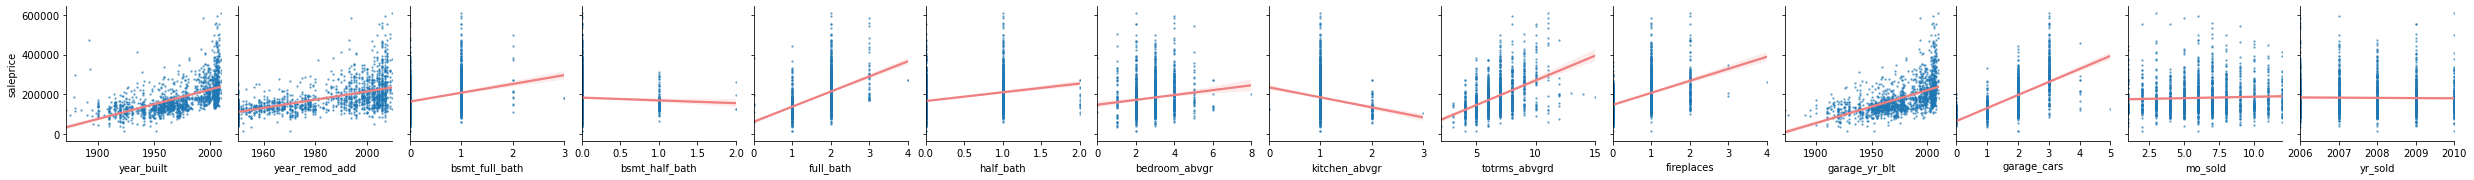

In [43]:
# to quickly visualise the range of values & relationship with target variable
sns.pairplot(
    data=train,
    x_vars=disc_features,
    y_vars='saleprice',
    kind='reg',
    plot_kws={
        'line_kws':{'color':'lightcoral'},
        'scatter_kws': {'s': 2, 'alpha': 0.5}
    },
    diag_kind=None,
);

We can see that `year_built`, `year_remod_add` & `garage_yr_blt` have a large range of values and have an approximate linear relationship with `saleprice` (albeit not a strong one), so we will classify them as *continuous*.

`mo_sold` and `yr_sold` appear to have no linear relationship with `saleprice`, so we will classify them as *nominal*.

The other 9 have a smaller range of values and some sort of linear relationship with `saleprice` as well, so we will classify them as *ordinal*.

In [44]:
# Creating a dictionary that classifies the features
feature_types = {
    'nominal': [
        'ms_subclass',
        'ms_zoning',
        'street',
        'alley',
        'land_contour',
        'lot_config',
        'neighborhood',
        'condition_1',
        'condition_2',
        'bldg_type',
        'house_style',
        'roof_style',
        'roof_matl',
        'exterior_1st',
        'exterior_2nd',
        'mas_vnr_type',
        'foundation',
        'heating',
        'central_air',
        'garage_type',
        'misc_feature',
        'mo_sold',
        'yr_sold',
        'sale_type'
    ],
    'ordinal': [
        'lot_shape',
        'utilities',
        'land_slope',
        'overall_qual',
        'overall_cond',
        'exter_qual',
        'exter_cond',
        'bsmt_qual',
        'bsmt_cond',
        'bsmt_exposure',
        'bsmtfin_type_1',
        'bsmtfin_type_2',
        'heating_qc',
        'electrical',
        'bsmt_full_bath',
        'bsmt_half_bath',
        'full_bath',
        'half_bath',
        'bedroom_abvgr',
        'kitchen_abvgr',
        'kitchen_qual',
        'totrms_abvgrd',
        'functional',
        'fireplaces',
        'fireplace_qu',
        'garage_finish',
        'garage_cars',
        'garage_cond',
        'paved_drive',
        'pool_qc',
        'fence'        
    ],
    'continuous': [
        'lot_frontage',
        'lot_area',
        'year_built',
        'year_remod_add',
        'mas_vnr_area',
        'bsmtfin_sf_1',
        'bsmtfin_sf_2',
        'bsmt_unf_sf',
        'total_bsmt_sf',
        '1st_flr_sf',
        '2nd_flr_sf',
        'low_qual_fin_sf',
        'gr_liv_area',
        'garage_yr_blt',
        'garage_area',
        'wood_deck_sf',
        'open_porch_sf',
        'enclosed_porch',
        '3ssn_porch',
        'screen_porch',
        'pool_area',
        'misc_val'
    ]
}

## Ranking Ordinal Features

Ordinal features can be treated two different ways - as nominal or ranked numerically. Treating it as nominal ignores any implied ordering in the ordinal feature and may result in overfitting the model. In this case, a more reasonable way to treat it would be to consider it as a numeric rank as the features are already defined as being ordinal in the data dictionary. Some feature engineering will be needed to transform the ordinal columns into ranked numeric values.

In [45]:
# Finding which ordinal features need to be transformed
for feature in feature_types['ordinal']:
    if train[feature].dtype == object:
        print(f'{feature}: {train[feature].unique()}')
        print(f'mode: {train[feature].mode()[0]}')
        if 'NA' in train[feature].unique():
            medians = train.groupby(feature)['saleprice'].median().to_dict()
            print(f'median sale prices: {medians}')
        print()

lot_shape: ['IR1' 'Reg' 'IR2' 'IR3']
mode: Reg

utilities: ['AllPub' 'NoSewr' 'NoSeWa']
mode: AllPub

land_slope: ['Gtl' 'Mod' 'Sev']
mode: Gtl

exter_qual: ['Gd' 'TA' 'Ex' 'Fa']
mode: TA

exter_cond: ['TA' 'Gd' 'Ex' 'Fa' 'Po']
mode: TA

bsmt_qual: ['NA' 'Gd' 'TA' 'Ex' 'Fa' 'Po']
mode: TA
median sale prices: {'Ex': 320000, 'Fa': 110750, 'Gd': 192000, 'NA': 98000, 'Po': 89000, 'TA': 135900}

bsmt_cond: ['NA' 'TA' 'Fa' 'Gd' 'Po' 'Ex']
mode: TA
median sale prices: {'Ex': 160000, 'Fa': 119375, 'Gd': 209200, 'NA': 98000, 'Po': 80775, 'TA': 165000}

bsmt_exposure: ['NA' 'No' 'Mn' 'Gd' 'Av']
mode: No
median sale prices: {'Av': 192140, 'Gd': 250000, 'Mn': 167000, 'NA': 98000, 'No': 150000}

bsmtfin_type_1: ['NA' 'Unf' 'ALQ' 'LwQ' 'Rec' 'GLQ' 'BLQ']
mode: GLQ
median sale prices: {'ALQ': 155000, 'BLQ': 143000, 'GLQ': 217000, 'LwQ': 139000, 'NA': 98000, 'Rec': 130625, 'Unf': 155863}

bsmtfin_type_2: ['NA' 'Unf' 'GLQ' 'LwQ' 'Rec' 'BLQ' 'ALQ']
mode: Unf
median sale prices: {'ALQ': 160000, 'BLQ': 14

We will create a dictionary of dictionaries for each column that needs to be transformed. The order of unique values in each column does not always follow rank so we must inspect them individually. Some values in the data dictionary are not in the training set, but we will include them in the dictionary anyway in case the test set has them. The method is as follows:

1. Arranging every ordinal feature numerically, assigning the mode for each feature `0` and the other values ranked accordingly.
2. For those with 'NA' values, assign an appropriate numeric rank based on median, since we cannot assume that NA is the worst value.

In [46]:
# Order numerically, lower means worse (following order from data dictionary)
ordinal_dict = {
    'lot_shape': {
        'IR3': -3,
        'IR2': -2,
        'IR1': -1,
        'Reg': 0
    },
    'utilities': {
        'ELO': -3,
        'NoSeWa': -2,
        'NoSewr': -1,
        'AllPub': 0
    },
    'land_slope': {
        'Sev': -2,
        'Mod': -1,
        'Gtl': 0
    },
    'exter_qual': {
        'Po': -2,
        'Fa': -1,
        'TA': 0,
        'Gd': 1,
        'Ex': 2
    },
    'exter_cond': {
        'Po': -2,
        'Fa': -1,
        'TA': 0,
        'Gd': 1,
        'Ex': 2
    },
    'bsmt_qual': {
        'NA': -2,
        'Po': -3,
        'Fa': -1,
        'TA': 0,
        'Gd': 1,
        'Ex': 2
    },
    'bsmt_cond': {
        'NA': -2,
        'Po': -3,
        'Fa': -1,
        'TA': 0,
        'Gd': 1,
        'Ex': 2
    },
    'bsmt_exposure': {
        'NA': -1,
        'No': 0,
        'Mn': 1,
        'Av': 2,
        'Gd': 3
    },
    'bsmtfin_type_1': {
        'NA': -6,
        'Unf': -5,
        'LwQ': -4,
        'Rec': -3,
        'BLQ': -2,
        'ALQ': -1,
        'GLQ': 0
    },
    'bsmtfin_type_2': {
        'NA': -1,
        'Unf': 0,
        'LwQ': 1,
        'Rec': 2,
        'BLQ': 3,
        'ALQ': 4,
        'GLQ': 5
    },
    'heating_qc': {
        'Po': -4,
        'Fa': -3,
        'TA': -2,
        'Gd': -1,
        'Ex': 0
    },
    'electrical': {
        'Mix': -4,
        'FuseP': -3,
        'FuseF': -2,
        'FuseA': -1,
        'SBrkr': 0
    },
    'kitchen_qual': {
        'Po': -2,
        'Fa': -1,
        'TA': 0,
        'Gd': 1,
        'Ex': 2
    },
    'functional': {
        'Sal': -7,
        'Sev': -6,
        'Maj2': -5,
        'Maj1': -4,
        'Mod': -3,
        'Min2': -2,
        'Min1': -1,
        'Typ': 0
    },
    'fireplace_qu': {
        'NA': 0,
        'Po': 1,
        'Fa': 2,
        'TA': 3,
        'Gd': 4,
        'Ex': 5
    },
    'garage_finish': {
        'NA': -1,
        'Unf': 0,
        'RFn': 1,
        'Fin': 2
    },
    'garage_cond': {
        'NA': -1,
        'Po': -3,
        'Fa': -2,
        'TA': 0,
        'Gd': 1,
        'Ex': 2
    },
    'paved_drive': {
        'N': -2,
        'P': -1,
        'Y': 0,
    },
    'pool_qc': {
        'NA': 0,
        'Fa': 1,
        'TA': 2,
        'Gd': 3,
        'Ex': 4
    },
    'fence': {
        'NA': 0,
        'MnWw': -4,
        'GdWo': -3,
        'MnPrv': -2,
        'GdPrv': -1
    }
}

In [47]:
# Map numeric rankings to ordinal features
for feature in feature_types['ordinal']:
    if train[feature].dtype == object:
        train[feature] = train[feature].map(ordinal_dict[feature])

In [48]:
# Checking that ordinal features are numeric
for feature in feature_types['ordinal']:
    print(f'{feature}: {train[feature].unique()}')

lot_shape: [-1  0 -2 -3]
utilities: [ 0 -1 -2]
land_slope: [ 0 -1 -2]
overall_qual: [ 7  8  6  5  4  9 10  3  2  1]
overall_cond: [5 6 7 8 4 9 3 2 1]
exter_qual: [ 1  0  2 -1]
exter_cond: [ 0  1  2 -1 -2]
bsmt_qual: [-2  1  0  2 -1 -3]
bsmt_cond: [-2  0 -1  1 -3  2]
bsmt_exposure: [-1  0  1  3  2]
bsmtfin_type_1: [-6 -5 -1 -4 -3  0 -2]
bsmtfin_type_2: [-1  0  5  1  2  3  4]
heating_qc: [-1 -2  0 -3 -4]
electrical: [ 0 -1 -2 -3 -4]
bsmt_full_bath: [0. 1. 3. 2.]
bsmt_half_bath: [0. 1. 2.]
full_bath: [2 1 3 0 4]
half_bath: [0 1 2]
bedroom_abvgr: [2 4 3 5 6 1 0 8]
kitchen_abvgr: [1 2 3 0]
kitchen_qual: [ 1  0  2 -1]
totrms_abvgrd: [ 5 10  4  6  7 11  8 12  9  3  2 14 13 15]
functional: [ 0 -4 -1 -5 -2 -3 -6 -7]
fireplaces: [0 1 2 3 4]
fireplace_qu: [0 3 4 5 2 1]
garage_finish: [ 1  2  0 -1]
garage_cars: [1. 2. 0. 3. 4. 5.]
garage_cond: [ 0 -1 -2  2  1 -3]
paved_drive: [ 0 -2 -1]
pool_qc: [0 1 3 2 4]
fence: [ 0 -1 -3 -2 -4]


One major problem with transforming ordinal features into ranked numeric features is that it requires the assumption that the numerical distance between each successive category (besides NA) is equal. However, this is rarely the case in real life. We will explore this issue further during the EDA later on.

# EDA

There are still a large number of features, and it is likely that many of these are noise and will not prove meaningful to the model later on. We can visualise the data to explore which features we can cut down on.

## Categorical Data

We will see the boxplot & bar chart for categorical features to visualise underlying distributions. We are looking to see how useful (or not useful) the feature would be in predicting sales prices.

For bar chart, we are looking out for features that are predominantly made up of one value/category. For these features, they would not be very useful as majority of the data would have the same value and it would not be meaningful in the model later on.

For box plot, we are looking out for the variance in IQRs between different values/categories in the feature. if all the IQRs are overlapping with each other, it may not be a useful feature as well as it does not show a clear relationship with sale price. 

In [49]:
# Creating a function to show a boxplot and barplot for each feature side by side
def subplot_box_hist(dataframe, list_of_features, figsize=()):
    nrows = len(list_of_features) # 1 row per feature, 2 plots per feature
    fsize = (14, len(list_of_features) * 5)
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=fsize, sharex=False, sharey=False)
    ax = ax.ravel()
    
    for i, feature in enumerate(list_of_features):
        # boxplot on the left
        sns.boxplot(
            ax=ax[i*2],
            data=dataframe,
            x=feature,
            y='saleprice',
            orient='v',
            linewidth=1,
            palette='viridis'
        )
        
        # bar chart on the right (histplot used to reflect proportion)
        if dataframe[feature].dtype == object:
            sns.histplot(
                data=dataframe,
                x=feature,
                ax=ax[(i*2 + 1)],
                hue=feature,
                stat='probability',
                palette='viridis',
                legend=False
            )
        else: # To avoid overlapping values in the same bin for numerical features
            sns.histplot(
                data=dataframe,
                x=feature,
                ax=ax[(i*2 + 1)],
                hue=feature,
                stat='probability',
                palette='viridis',
                legend=False,
                discrete=True
            )
        
        ax[i*2].set_xlabel(feature, fontsize=14, fontweight='bold')
        ax[(i*2) + 1].set_xlabel(feature, fontsize=14, fontweight='bold')
        
    fig.tight_layout()

### Nominal Features


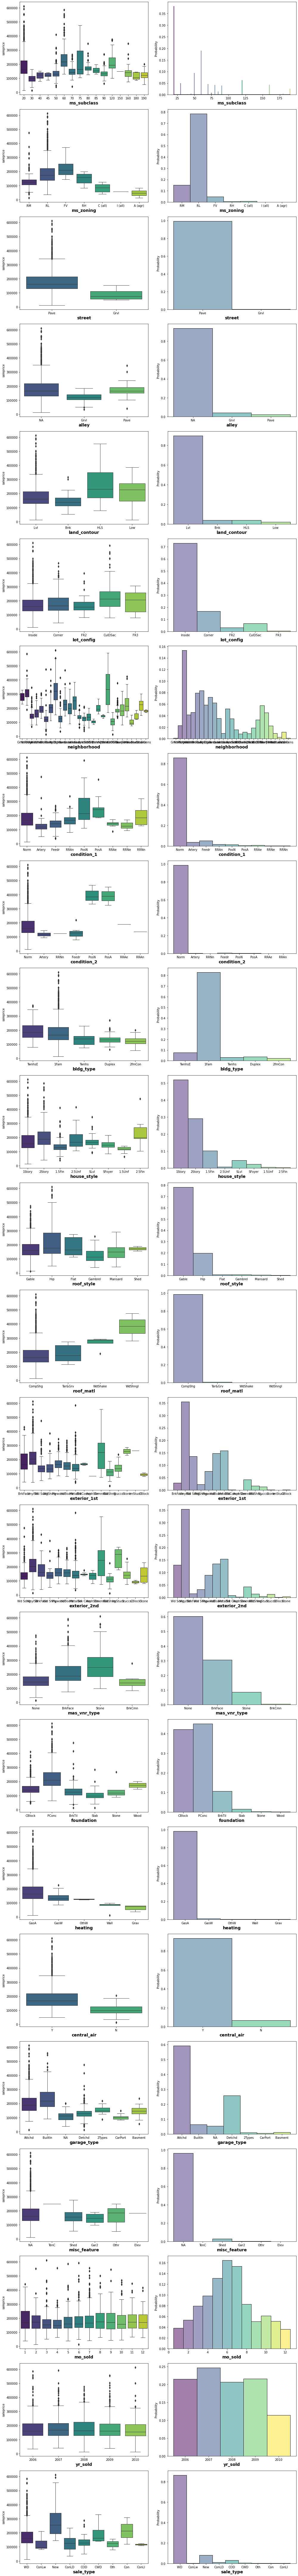

In [50]:
subplot_box_hist(train, feature_types['nominal'])

The steps used in elimination are as follows:
1. Inspect bar charts, features with extreme skew in values (>95% dominance of one value/category): drop
    - Features with noticeable skew in values (80 - 95%): inspect boxplot, if no clear trend in relationship with `saleprice`, drop
2. Inspect box plots, if IQRs of all values/categories overlap, drop
    - This step not as stringent, as even if one category has a noticeable effect on price, it could be useful in model later on
    - Some not sure, better to leave it to feature selection step later on
    
Nominal features dropped:
> 1. street
2. alley
3. condition_1
4. condition_2
5. roof_matl
6. heating
7. misc_feature
8. mo_sold

In [51]:
# List of nominal features to drop
nominal_feature_drop = [
    'street',
    'alley',
    'condition_1',
    'condition_2', 
    'roof_matl',
    'heating', 
    'misc_feature',
    'mo_sold'
]

In [52]:
# Dropping stated features from the dataframe
train.drop(columns=nominal_feature_drop, inplace=True)

In [53]:
# Updating feature classification dictionary
for feature in nominal_feature_drop:
    feature_types['nominal'].remove(feature)

### Ordinal features


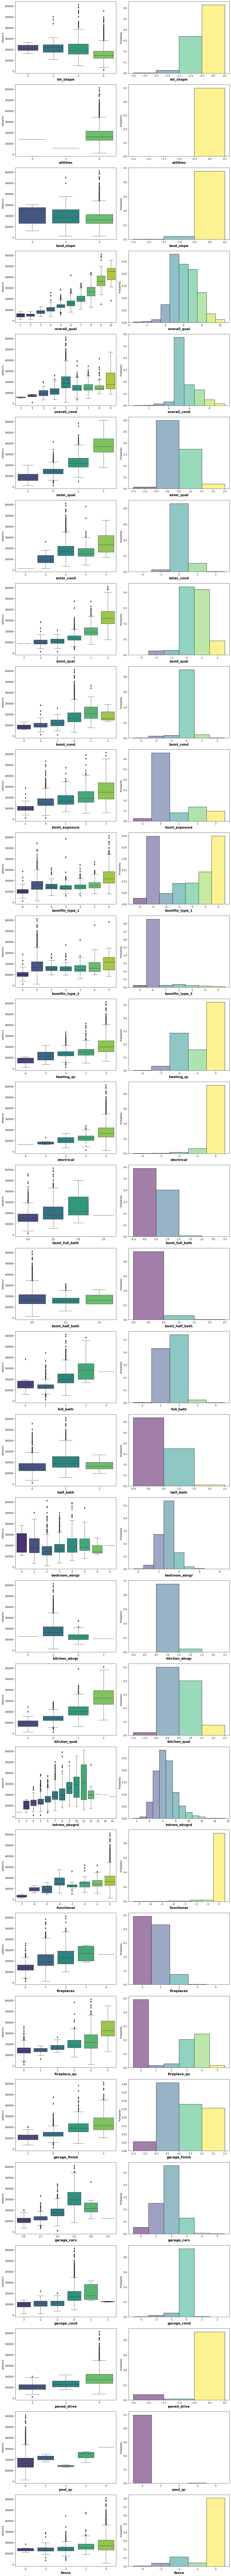

In [54]:
subplot_box_hist(train, feature_types['ordinal'])

The method used in elimination is similar to nominal, but we pay more attention to the boxplot because the distribution of sale prices in ordinal features should reflect some sort of trend in relation to their feature value.

1. Inspect bar charts, features with extreme skew in values (>95% dominance of one value/category): drop
    - Features with noticeable skew in values (80 - 95%): inspect boxplot, if no clear trend in relationship with saleprice, drop
2. Inspect box plots, IQRs of successive values should reflect a trend with sale price

Step 2, similar to the nominal features, will not be very stringent. We will not simply be dropping features that have irregularities in the trend (e.g. `overall_cond`) unless there seems to be no noticeable trend at all (e.g. `pool_qc`). Furthermore, we will be combining and transforming some of these features later on.

Earlier, we mentioned the issue with numerically ranked ordinal features in that it requires the assumption that the numerical distance between each successive category is equal. However, this isn't the case for many of the features, such as `overall_qual`:

![overall_qual boxplot against sale_price](../images/ordinal_numeric_rank_example.png "Boxplot of Overall Quality vs Sale Price")

As can be seen, the median sale price does not increase linearly with the overall quality of the house. However, in the model, a linear coefficient is given to the feature and thus the feature will have a linearly proportional effect on the sale price in the model.

One method that was considered was to assign a numeric value to each category in the ordinal feature that was proportionate to the mean or median of the corresponding sale prices. This would help to alleviate the issue of linear differences between successive categories in the ordinal feature. However, this would be overfitting to the training set and will likely result in a higher variance, meaning that the model produced would not perform as well when exposed to new data (i.e. the test set).

It would eventually be a trade-off between bias and variance either way as we are trying to get the values in the ordinal features to best reflect the reality of their relationship with sales prices. Inspecting the box plots further, there seem to be no extreme cases where the distance between values are too unequal, so we will not be transforming the numerical values further to avoid overfitting.

Ordinal features dropped:
> 1. utilities
2. land_slope
3. kitchen_abvgr
4. functional
5. garage_cond
6. pool_qc
7. fence

In [55]:
# List of ordinal features to drop
ordinal_feature_drop = [
    'utilities',
    'land_slope',
    'kitchen_abvgr',
    'functional', 
    'garage_cond',
    'pool_qc',
    'fence'
] 

In [56]:
# Dropping stated features from the dataframe
train.drop(columns=ordinal_feature_drop, inplace=True)

In [57]:
# Updating feature classification dictionary
for feature in ordinal_feature_drop:
    feature_types['ordinal'].remove(feature)

## Continuous Data

We can explore continuous features with pairplots against `saleprice`

In [58]:
# Creating a function to show scatter plots of feature against sale price
def subplot_scatter(dataframe, list_of_features, figsize=()):
    nrows = int(np.ceil(len(list_of_features)/2))
    fsize = (14, nrows * 5)
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=fsize, sharex=False, sharey=True)
    ax = ax.ravel()
    
    for i, feature in enumerate(list_of_features):      
        sns.regplot(
            data=dataframe,
            x=feature, 
            y='saleprice', 
            ax=ax[i],
            scatter_kws={'s': 4, 'alpha': 0.5},
            line_kws={'color':'lightcoral'}
        )

        ax[i].set_xlabel(feature, fontsize=14, fontweight='bold')
         
    fig.tight_layout()

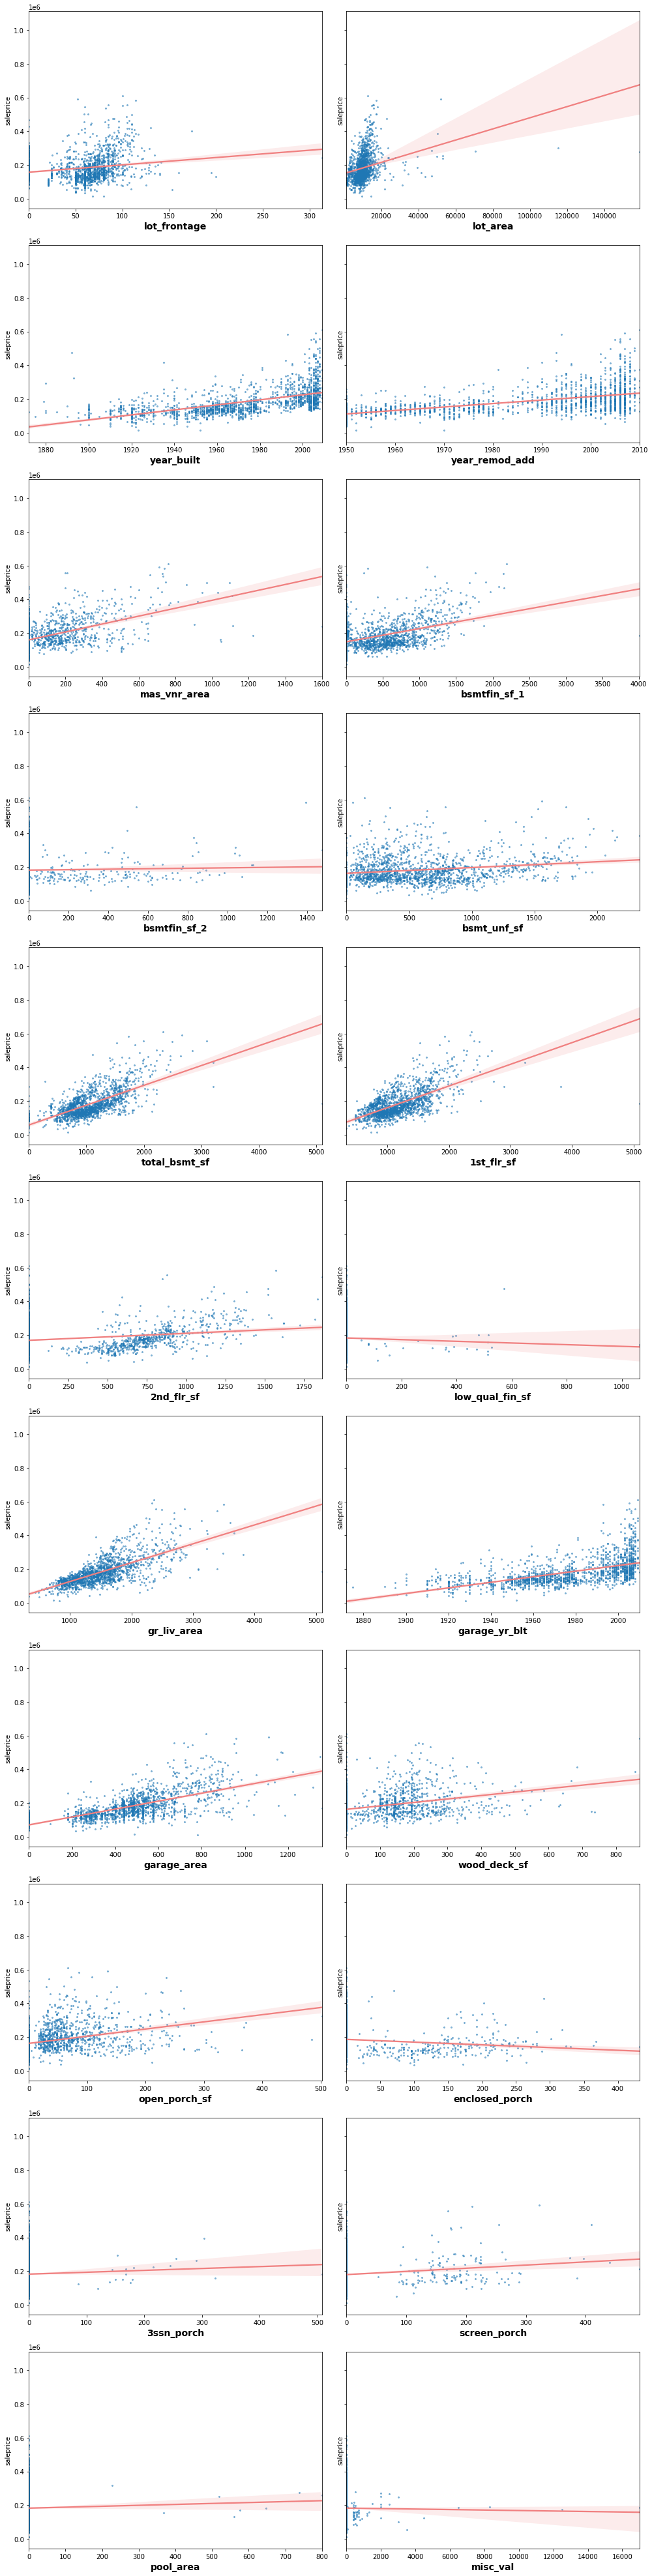

In [59]:
subplot_scatter(train, feature_types['continuous'])

Some of the features have a large number of observations with a value of 0, and thus may not be very useful in our model. These are usually related to features that are not in many houses, such as certain types of porches. For these, we will examine them case by case, as we may be combining or modifying these features later on.

Continuous features dropped:
> 1. low_qual_fin_sf
2. pool_area
3. misc_val

In [60]:
# List of continuous features to drop
continuous_feature_drop = [
    'low_qual_fin_sf',
    'pool_area',
    'misc_val',
] 

In [61]:
# Dropping stated features from the dataframe
train.drop(columns=continuous_feature_drop, inplace=True)

In [62]:
# Updating feature classification dictionary
for feature in continuous_feature_drop:
    feature_types['continuous'].remove(feature)

## Feature Combinations & Interactions

We still have many features, many of which are of a similar nature (i.e. describing similar features about the house). They may have multicollinearity between the features, which will reduce the model's performance due to overfitting.

We can explore relationships between the numerical features by exploring their correlation coefficients, then see whether we want to combine, transform or create new interaction features (representing the interaction effect between two separate features).

In [63]:
# Creating a function to plot heatmap
def plot_heatmap(df, title, cols=train.columns, figsize=(14,14), annot=False, absolute=True):
    fig, ax = plt.subplots(figsize=figsize)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(df[cols].corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Use absolute value to have a better visualisation of collinear features
    if absolute == True:
        data = df[cols].corr().abs()
    # Include negative numbers for deeper study of feature relationships
    else:
        data = df[cols].corr()
    
    ax = sns.heatmap(
        data,
        mask=mask,
        ax=ax,
        annot=annot,
        cmap='flare'
    ) 
    
    ax.set_title(title, fontsize=24)
    fig.tight_layout()

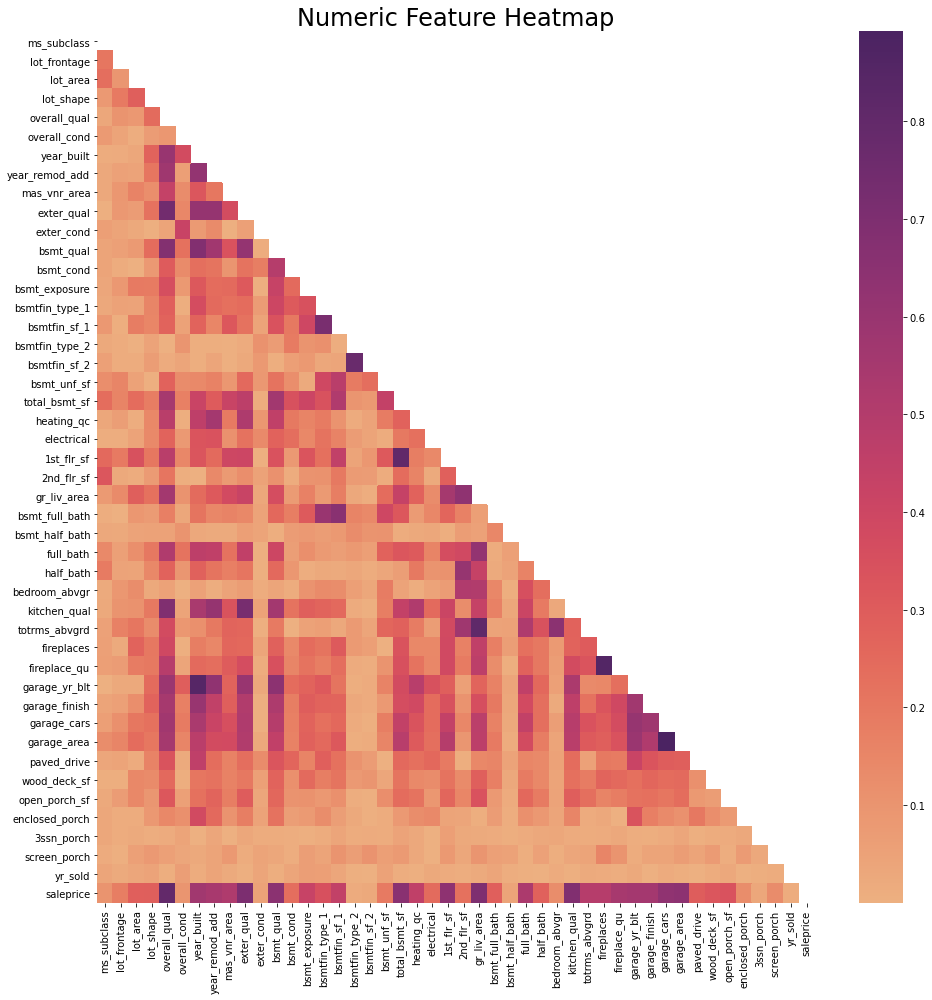

In [64]:
plot_heatmap(train, 'Numeric Feature Heatmap')

The darker spots on the heatmap indicate features with higher correlation values. However, with such a large number of features, it's difficult to isolate any pair of features from the heatmap alone. We will be grouping a few features together based on the nature of what they are describing and then explore their relationships from there.

### Property Age

There are two separate features related to the year the property was built/sold - 'year_built' & 'yr_sold'. the exact year is not very meaningful to us - we can combine the two into a single feature describing the age of the property instead. We can also transform the 'year_remod_add' & 'garage_yr_built' features to reflect the age of the respective property features.

In [65]:
# Combining features to create new features
train['property_age'] = train['yr_sold'] - train['year_built']
train['garage_age'] = train['yr_sold'] - train['garage_yr_blt']
train['age_remod_add'] = train['year_remod_add'] - train['year_built']

In [66]:
# Dropping features describing exact years
train.drop(columns=['yr_sold', 'year_built', 'garage_yr_blt', 'year_remod_add'], inplace=True)

### Porch Features

There are 4 features describing porch areas for different types of porches. We will study their heatmap to explore the possibility of combining them.

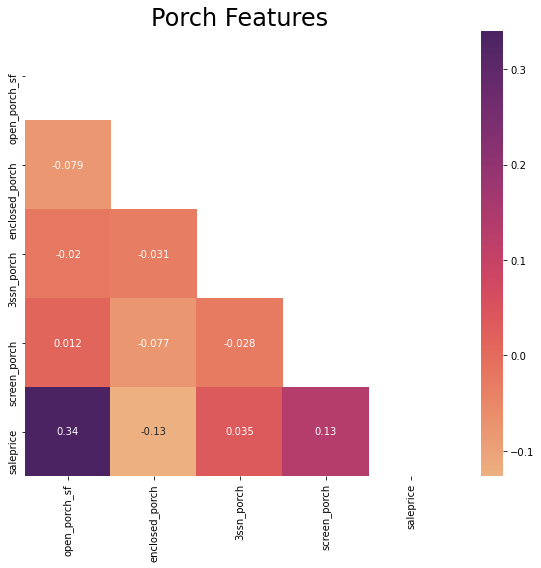

In [67]:
plot_heatmap(
    train, 
    'Porch Features',
    ['open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch', 'saleprice'],
    figsize=(8,8), 
    annot=True,
    absolute=False
)

However, upon studying their heatmap, it appears that there is very low correlation amongst these features. Furthermore, `enclosed_porch` has a negative correlation with `saleprice`, which indicates that having an enclosed porch may not lead to a higher sale price. Thus, we will not be combining these features as it may have an adverse effect on the accuracy of the model later on.

### Quality & Condition 

There are a few features which describe either quality or condition of certain aspects of the house - overall, exterior & basement. We will study their heatmap to see if these are worth manipulating.

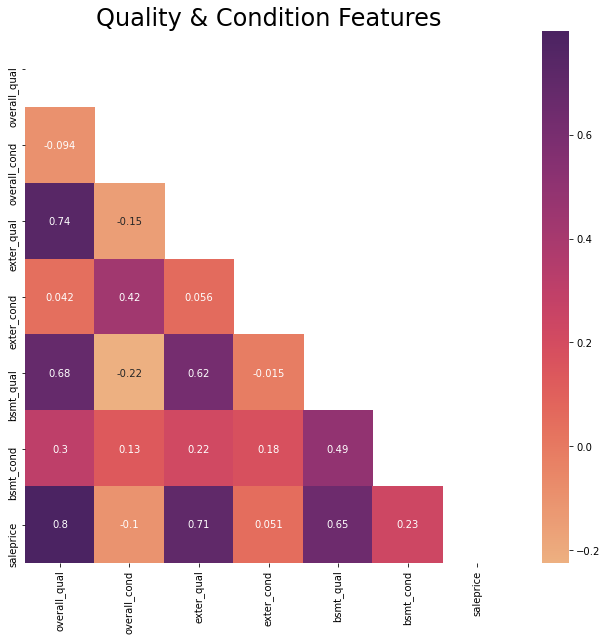

In [68]:
plot_heatmap(
    train, 
    'Quality & Condition Features',
    ['overall_qual', 'overall_cond', 'exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond', 'saleprice'],
    figsize=(9,9), 
    annot=True,
    absolute=False
)

From the heatmap, they all have positive correlations with sale price, except for overall condition. We will multiply the quality and condition features with each other to create interaction features for just the exterior and basement instead.

In [69]:
# Combining quality & condition features
train['exter_qual_cond'] = train['exter_qual'] * train['exter_cond']
train['bsmt_qual_cond'] = train['bsmt_qual'] * train['bsmt_cond']

### Features Related to Size

There are several features related to the size of the property sold. These may have some collinearity because some of the features are describing the size of subsets of other features, e.g. size of separate basement types and overall size of basement.

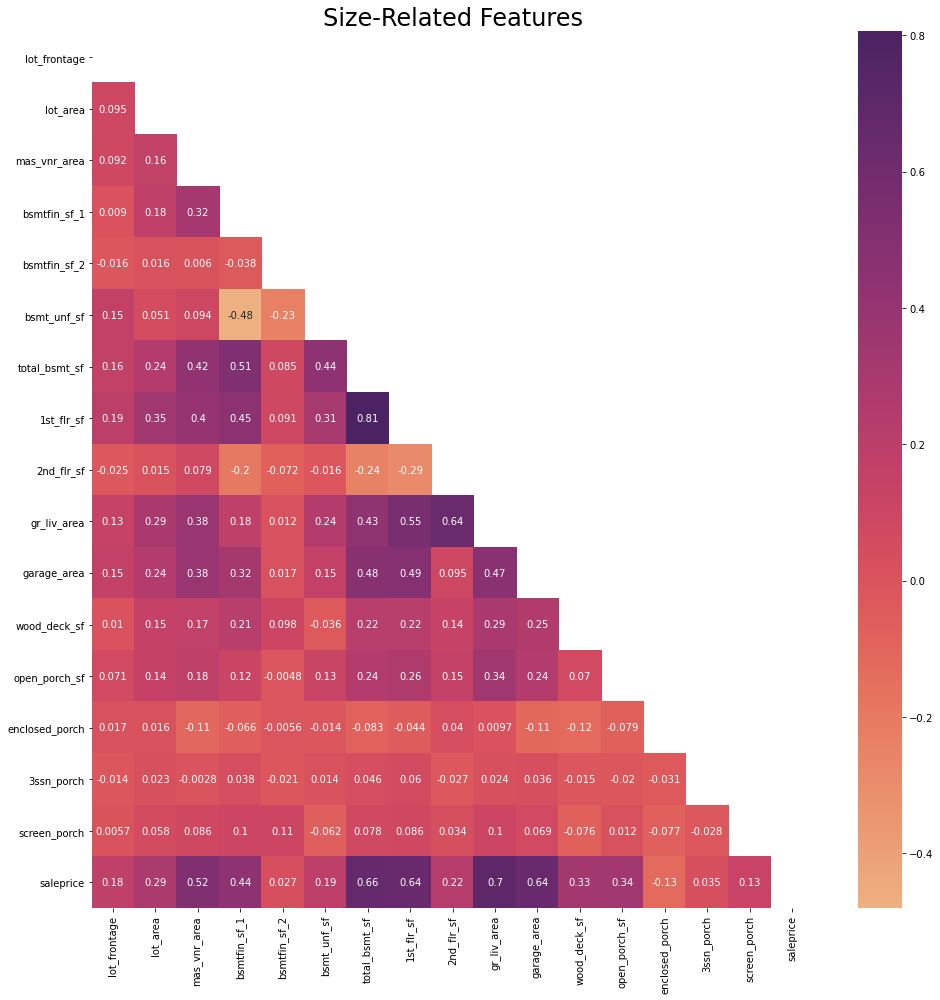

In [70]:
plot_heatmap(
    train, 
    'Size-Related Features',
    ['lot_frontage', 'lot_area', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 
     'bsmt_unf_sf', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area',
     'garage_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', 
     '3ssn_porch', 'screen_porch', 'saleprice'],
    figsize=(14,14), 
    annot=True,
    absolute=False
)

Surprisingly, not many of the features related to size were highly correlated to each other. Even for the features with extremely high correlation values such as `1st_flr_sf` & `total_bsmt_sf`, we will not be dropping them as they are deemed too important (judging from their high correlation value with saleprice).

However, we can still create interaction features for the feature pairs with significant correlation values, to see if these new features have a bigger effect on the model later on.

In [71]:
# Creating interaction features for feature pairs with absolute correlation value > 0.5
train['1st_flr_sf_total_bsmt_sf'] = train['1st_flr_sf'] * train['total_bsmt_sf']
train['bsmtfin_sf_1_total_bsmt_sf'] = train['bsmtfin_sf_1'] * train['total_bsmt_sf']
train['gr_liv_area_2nd_flr_sf'] = train['gr_liv_area'] * train['2nd_flr_sf']
train['gr_liv_area_1st_flr_sf'] = train['gr_liv_area'] * train['1st_flr_sf']

In [72]:
train

,ms_subclass,ms_zoning,lot_frontage,lot_area,lot_shape,land_contour,lot_config,neighborhood,bldg_type,house_style,overall_qual,overall_cond,roof_style,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_qual,totrms_abvgrd,fireplaces,fireplace_qu,garage_type,garage_finish,garage_cars,garage_area,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,sale_type,saleprice,property_age,garage_age,age_remod_add,exter_qual_cond,bsmt_qual_cond,1st_flr_sf_total_bsmt_sf,bsmtfin_sf_1_total_bsmt_sf,gr_liv_area_2nd_flr_sf,gr_liv_area_1st_flr_sf
0,120,RM,0.0,8239,-1,Lvl,Inside,GrnHill,TwnhsE,1Story,7,5,Gable,BrkFace,Wd Sdng,None,0.0,1,0,CBlock,-2,-2,-1,-6,0.0,-1,0.0,0.0,0.0,-1,Y,0,1295,0,1295,0.0,0.0,2,0,2,1,5,0,0,Attchd,1,1.0,312.0,0,0,0,0,0,0,WD,230000,20,20.0,0,0,4,0.0,0.0,0,1677025
1,60,RL,93.0,12090,0,Lvl,Corner,NoRidge,1Fam,2Story,8,5,Hip,VinylSd,VinylSd,BrkFace,650.0,1,0,PConc,1,0,0,-5,0.0,0,0.0,1141.0,1141.0,-1,Y,0,1165,1098,2263,0.0,0.0,2,1,4,1,10,1,3,BuiltIn,2,2.0,420.0,0,144,123,0,0,0,WD,258000,8,8.0,0,0,0,1329265.0,0.0,2484774,2636395
2,20,RL,87.0,10000,-1,Lvl,Corner,NAmes,1Fam,1Story,6,6,Hip,Wd Sdng,Wd Sdng,BrkFace,261.0,0,0,CBlock,0,0,0,-5,0.0,0,0.0,1116.0,1116.0,-2,Y,0,1116,0,1116,0.0,0.0,1,1,3,0,5,0,0,Attchd,0,2.0,440.0,0,0,0,0,0,385,WD,160000,48,48.0,0,0,0,1245456.0,0.0,0,1245456
3,20,RL,57.0,8280,-1,Lvl,Inside,NAmes,1Fam,1Story,6,5,Gable,BrkFace,BrkFace,None,0.0,0,0,CBlock,0,0,0,-5,0.0,0,0.0,932.0,932.0,0,Y,-1,932,0,932,0.0,0.0,1,0,2,1,4,1,4,Attchd,0,1.0,306.0,0,0,0,214,0,0,WD,124000,57,57.0,0,0,0,868624.0,0.0,0,868624
4,60,RL,78.0,11419,0,Lvl,Corner,NAmes,1Fam,2Story,7,7,Gable,WdShing,Wd Shng,None,0.0,0,0,CBlock,0,0,1,-1,699.0,0,0.0,0.0,699.0,0,Y,-1,801,726,1527,1.0,0.0,1,1,3,0,6,1,4,Attchd,0,2.0,410.0,0,0,0,134,0,0,WD,152500,61,61.0,51,0,0,559899.0,488601.0,1108602,1223127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,20,RL,68.0,9450,0,Bnk,Inside,Edwards,1Fam,1Story,4,5,Gable,MetalSd,MetalSd,None,0.0,0,0,CBlock,0,0,0,-4,552.0,0,0.0,342.0,894.0,0,Y,0,894,0,894,0.0,0.0,1,0,3,0,5,0,0,Detchd,0,2.0,400.0,0,0,0,0,0,0,WD,110000,53,8.0,0,0,0,799236.0,493488.0,0,799236
1636,120,RL,55.0,7892,0,Lvl,Inside,SawyerW,TwnhsE,1Story,6,5,Gable,Plywood,Plywood,None,0.0,0,0,CBlock,1,0,0,-5,0.0,0,0.0,918.0,918.0,-2,Y,0,918,0,918,0.0,0.0,2,0,2,0,5,1,3,Attchd,0,1.0,264.0,0,28,0,0,0,0,WD,99500,31,31.0,0,0,0,842724.0,0.0,0,842724
1637,85,RL,57.0,8846,-1,Lvl,CulDSac,CollgCr,1Fam,SFoyer,5,5,Gable,VinylSd,VinylSd,None,0.0,1,0,PConc,1,0,2,0,298.0,0,0.0,572.0,870.0,0,Y,0,914,0,914,0.0,0.0,1,0,2,0,5,0,0,Detchd,0,2.0,576.0,0,0,0,0,0,0,WD,148000,10,8.0,0,0,0,795180.0,259260.0,0,835396
1638,60,RL,0.0,12585,-1,Lvl,Inside,NoRidge,1Fam,2Story,8,5,Gable,HdBoard,ImStucc,BrkFace,420.0,1,0,PConc,1,0,0,-4,247.0,5,1039.0,0.0,1286.0,0,Y,0,1565,1234,2799,1.0,0.0,2,1,3,1,8,1,3,Attchd,2,3.0,704.0,0,432,136,0,0,0,WD,315000,13,13.0,0,0,0,2012590.0,317642.0,3453966,4380435


### Bathroom Features

There are a few features describing the number of full/half baths in the property as well, we will study their heatmap to see if we find anything interesting.

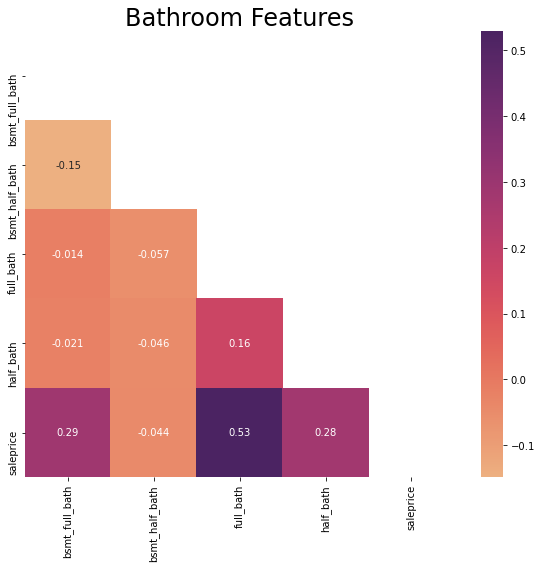

In [73]:
plot_heatmap(
    train, 
    'Bathroom Features',
    ['bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'saleprice'],
    figsize=(8,8), 
    annot=True,
    absolute=False
)

Unfortunately, their heatmap does not tell us anything particularly useful. None of the features have high pairwise correlation with one another. However, we would expect some sort of relationship between these features as they are describing very similar things.

As explored earlier, some of these ordinal features have some irregularities in their boxplot trends. We will create some new features that may add greater predictive value to our model later on.

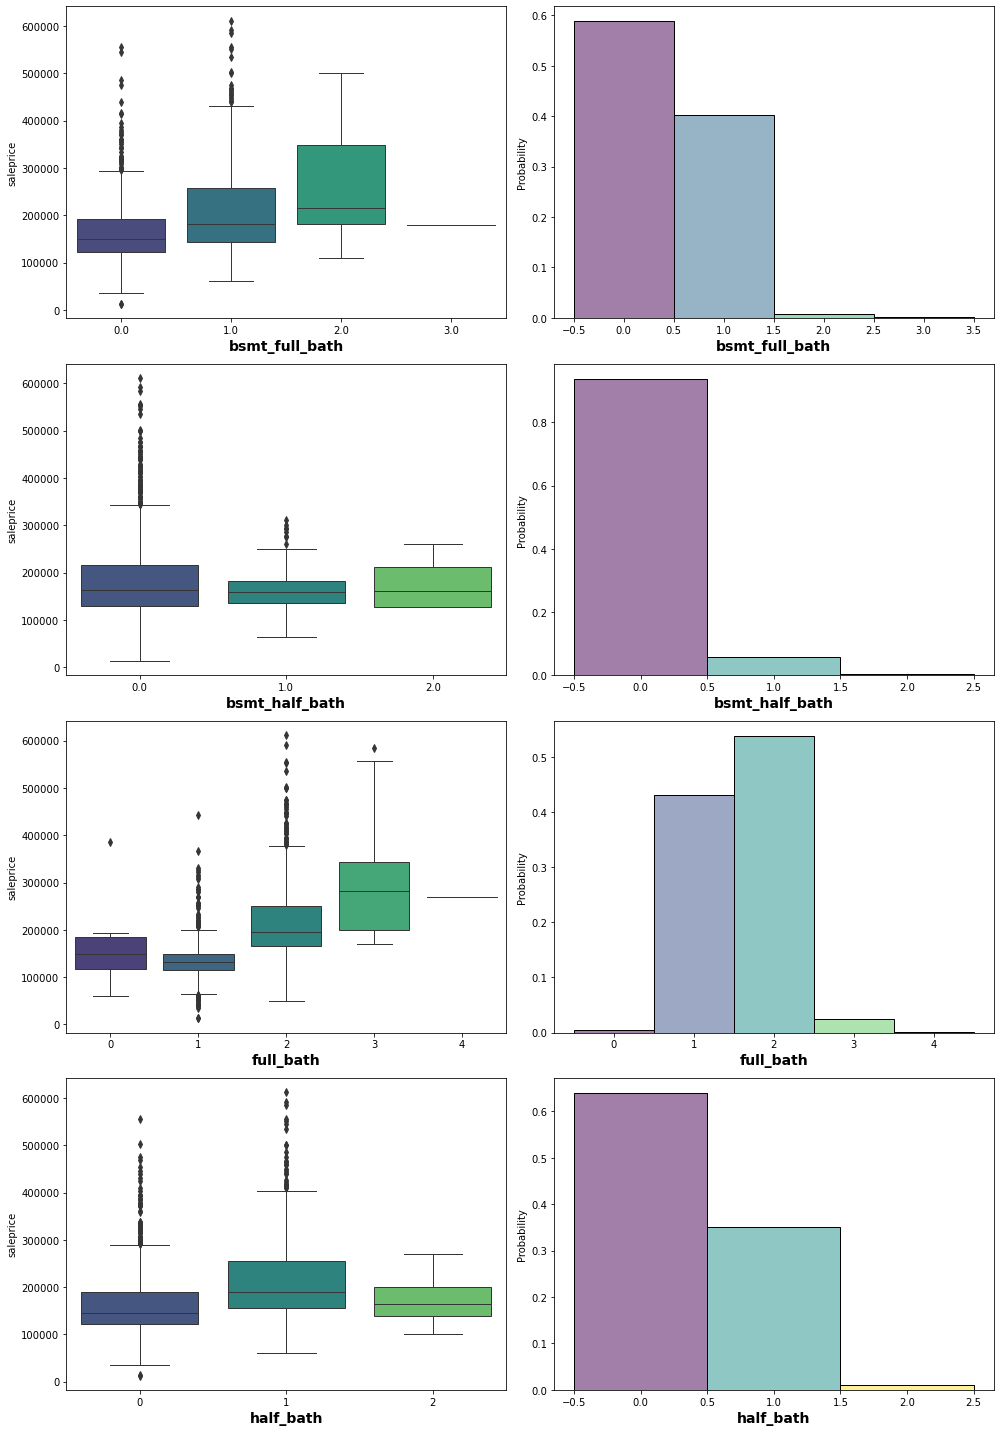

In [74]:
# Visualising ordinal trends for bathroom related features
subplot_box_hist(train, ['bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath'])

In [75]:
# Creating additional features related to bathrooms
train['bsmt_total_bath'] = train['bsmt_full_bath'] + 0.5 * train['bsmt_half_bath']
train['total_bath'] = train['full_bath'] + 0.5 * train['half_bath']

## Outliers

Referring to the data dictionary, there are a couple of outliers that we will remove based on the plot of `sale_price` against `gr_liv_area`. These are unusual sales due to the condition or the size of the sales themselves. Unfortunately, we are unable to find the relationship between the sale condition and the sale price as the feature is missing from this particular dataset.

In [76]:
# Removing outliers (houses with >4000 sq ft)
train.drop(index=train.loc[train['gr_liv_area'] > 4000, :].index, inplace=True)

However, aside from this, we will not be removing any other outliers from the training data set due to the fact that these outliers do exist in reality, and correspondingly in the test set as well. Removal of more outliers might lead to a better test score for the model but may not accurately reflect the presence of these true outliers.

### Updating Dictionaries

In [77]:
# List of features dropped
nominal_feature_drop_2 = 'yr_sold'
continuous_feature_drop_2 = [
    'year_built',
    'garage_yr_blt',
    'year_remod_add'
] 

# List of features added
ordinal_feature_add = [
    'exter_qual_cond',
    'bsmt_qual_cond', 
    'bsmt_total_bath', 
    'total_bath'
]
continuous_feature_add = [
    'property_age', 
    'garage_age', 
    'age_remod_add',
    '1st_flr_sf_total_bsmt_sf',
    'bsmtfin_sf_1_total_bsmt_sf',
    'gr_liv_area_2nd_flr_sf',
    'gr_liv_area_1st_flr_sf'
]

In [78]:
# Updating feature classification dictionary
feature_types['nominal'].remove(nominal_feature_drop_2)

for feature in continuous_feature_drop_2:
    feature_types['continuous'].remove(feature)
    
for feature in ordinal_feature_add:
    feature_types['ordinal'].append(feature)
    
for feature in continuous_feature_add:
    feature_types['continuous'].append(feature)

# Preprocessing

Now that all the exploratory data analysis & cleaning is done, we can start to think about building our model. However, first we have to encode the data so that it is able to be processed by the model.

## One-Hot Encoding

Some features in our dataset are still object types or non-ordered numerical values, and will need to be converted into a series of binary variables for each value in the feature. This process is called one-hot encoding, and we will apply this to the nominal features in our dataset.

In [79]:
# Reset index of train set for preprocessing
train.reset_index(drop=True, inplace=True)

In [80]:
# Instantiate OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore') 
# Ignore unknown variables when transforming validation/test set
# Avoid dropping first, might drop cols differently for train/test sets leading to loss of data

# Fit to train set & transform
train_nominal = train[feature_types['nominal']]
train_ohe = ohe.fit_transform(train_nominal)

# Create a df with one hot encoded features
train_ohe_df = pd.DataFrame(train_ohe.toarray(), columns=ohe.get_feature_names())

# Join df back to main train dataframe, drop original nominal feature columns
train = train.join(train_ohe_df).drop(columns=feature_types['nominal'])

In [81]:
# Checking to see one hot encoded features
train

,lot_frontage,lot_area,lot_shape,overall_qual,overall_cond,mas_vnr_area,exter_qual,exter_cond,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating_qc,electrical,1st_flr_sf,2nd_flr_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_qual,totrms_abvgrd,fireplaces,fireplace_qu,garage_finish,garage_cars,garage_area,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,saleprice,property_age,garage_age,age_remod_add,exter_qual_cond,bsmt_qual_cond,1st_flr_sf_total_bsmt_sf,bsmtfin_sf_1_total_bsmt_sf,gr_liv_area_2nd_flr_sf,gr_liv_area_1st_flr_sf,bsmt_total_bath,total_bath,x0_20,x0_30,x0_40,x0_45,x0_50,x0_60,x0_70,x0_75,x0_80,x0_85,x0_90,x0_120,x0_150,x0_160,x0_180,x0_190,x1_A (agr),x1_C (all),x1_FV,x1_I (all),x1_RH,x1_RL,x1_RM,x2_Bnk,x2_HLS,x2_Low,x2_Lvl,x3_Corner,x3_CulDSac,x3_FR2,x3_FR3,x3_Inside,x4_Blmngtn,x4_Blueste,x4_BrDale,x4_BrkSide,x4_ClearCr,x4_CollgCr,x4_Crawfor,x4_Edwards,x4_Gilbert,x4_Greens,x4_GrnHill,x4_IDOTRR,x4_MeadowV,x4_Mitchel,x4_NAmes,x4_NPkVill,x4_NWAmes,x4_NoRidge,x4_NridgHt,x4_OldTown,x4_SWISU,x4_Sawyer,x4_SawyerW,x4_Somerst,x4_StoneBr,x4_Timber,x4_Veenker,x5_1Fam,x5_2fmCon,x5_Duplex,x5_Twnhs,x5_TwnhsE,x6_1.5Fin,x6_1.5Unf,x6_1Story,x6_2.5Fin,x6_2.5Unf,x6_2Story,x6_SFoyer,x6_SLvl,x7_Flat,x7_Gable,x7_Gambrel,x7_Hip,x7_Mansard,x7_Shed,x8_AsbShng,x8_AsphShn,x8_BrkComm,x8_BrkFace,x8_CBlock,x8_CemntBd,x8_HdBoard,x8_ImStucc,x8_MetalSd,x8_Plywood,x8_Stone,x8_Stucco,x8_VinylSd,x8_Wd Sdng,x8_WdShing,x9_AsbShng,x9_AsphShn,x9_Brk Cmn,x9_BrkFace,x9_CBlock,x9_CmentBd,x9_HdBoard,x9_ImStucc,x9_MetalSd,x9_Plywood,x9_Stone,x9_Stucco,x9_VinylSd,x9_Wd Sdng,x9_Wd Shng,x10_BrkCmn,x10_BrkFace,x10_None,x10_Stone,x11_BrkTil,x11_CBlock,x11_PConc,x11_Slab,x11_Stone,x11_Wood,x12_N,x12_Y,x13_2Types,x13_Attchd,x13_Basment,x13_BuiltIn,x13_CarPort,x13_Detchd,x13_NA,x14_COD,x14_CWD,x14_Con,x14_ConLD,x14_ConLI,x14_ConLw,x14_New,x14_Oth,x14_WD
0,0.0,8239,-1,7,5,0.0,1,0,-2,-2,-1,-6,0.0,-1,0.0,0.0,0.0,-1,0,1295,0,1295,0.0,0.0,2,0,2,1,5,0,0,1,1.0,312.0,0,0,0,0,0,0,230000,20,20.0,0,0,4,0.0,0.0,0,1677025,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,93.0,12090,0,8,5,650.0,1,0,1,0,0,-5,0.0,0,0.0,1141.0,1141.0,-1,0,1165,1098,2263,0.0,0.0,2,1,4,1,10,1,3,2,2.0,420.0,0,144,123,0,0,0,258000,8,8.0,0,0,0,1329265.0,0.0,2484774,2636395,0.0,2.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,87.0,10000,-1,6,6,261.0,0,0,0,0,0,-5,0.0,0,0.0,1116.0,1116.0,-2,0,1116,0,1116,0.0,0.0,1,1,3,0,5,0,0,0,2.0,440.0,0,0,0,0,0,385,160000,48,48.0,0,0,0,1245456.0,0.0,0,1245456,0.0,1.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0

In [82]:
train.dtypes.value_counts()

float64    151
int64       37
dtype: int64

## Scaling

We will need to standardise our features so that the scale will not affect their penalisation later on during the modelling stage. We will apply this to the ordinal and continuous variables.

In [83]:
# Instantiate StandardScaler
ss = StandardScaler()

# Fit to train set & transform
scale_cols = feature_types['ordinal'] + feature_types['continuous']
train_scale = train[scale_cols]
train_ss = ss.fit_transform(train_scale)

# Create a df with scaled features
train_ss_df = pd.DataFrame(train_ss, columns=scale_cols)

# Join df back to main train dataframe, drop original feature columns
train = train.drop(columns=scale_cols).join(train_ss_df)

In [84]:
# Checking to see scaled features
train

,saleprice,x0_20,x0_30,x0_40,x0_45,x0_50,x0_60,x0_70,x0_75,x0_80,x0_85,x0_90,x0_120,x0_150,x0_160,x0_180,x0_190,x1_A (agr),x1_C (all),x1_FV,x1_I (all),x1_RH,x1_RL,x1_RM,x2_Bnk,x2_HLS,x2_Low,x2_Lvl,x3_Corner,x3_CulDSac,x3_FR2,x3_FR3,x3_Inside,x4_Blmngtn,x4_Blueste,x4_BrDale,x4_BrkSide,x4_ClearCr,x4_CollgCr,x4_Crawfor,x4_Edwards,x4_Gilbert,x4_Greens,x4_GrnHill,x4_IDOTRR,x4_MeadowV,x4_Mitchel,x4_NAmes,x4_NPkVill,x4_NWAmes,x4_NoRidge,x4_NridgHt,x4_OldTown,x4_SWISU,x4_Sawyer,x4_SawyerW,x4_Somerst,x4_StoneBr,x4_Timber,x4_Veenker,x5_1Fam,x5_2fmCon,x5_Duplex,x5_Twnhs,x5_TwnhsE,x6_1.5Fin,x6_1.5Unf,x6_1Story,x6_2.5Fin,x6_2.5Unf,x6_2Story,x6_SFoyer,x6_SLvl,x7_Flat,x7_Gable,x7_Gambrel,x7_Hip,x7_Mansard,x7_Shed,x8_AsbShng,x8_AsphShn,x8_BrkComm,x8_BrkFace,x8_CBlock,x8_CemntBd,x8_HdBoard,x8_ImStucc,x8_MetalSd,x8_Plywood,x8_Stone,x8_Stucco,x8_VinylSd,x8_Wd Sdng,x8_WdShing,x9_AsbShng,x9_AsphShn,x9_Brk Cmn,x9_BrkFace,x9_CBlock,x9_CmentBd,x9_HdBoard,x9_ImStucc,x9_MetalSd,x9_Plywood,x9_Stone,x9_Stucco,x9_VinylSd,x9_Wd Sdng,x9_Wd Shng,x10_BrkCmn,x10_BrkFace,x10_None,x10_Stone,x11_BrkTil,x11_CBlock,x11_PConc,x11_Slab,x11_Stone,x11_Wood,x12_N,x12_Y,x13_2Types,x13_Attchd,x13_Basment,x13_BuiltIn,x13_CarPort,x13_Detchd,x13_NA,x14_COD,x14_CWD,x14_Con,x14_ConLD,x14_ConLI,x14_ConLw,x14_New,x14_Oth,x14_WD,lot_shape,overall_qual,overall_cond,exter_qual,exter_cond,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_type_2,heating_qc,electrical,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_qual,totrms_abvgrd,fireplaces,fireplace_qu,garage_finish,garage_cars,paved_drive,exter_qual_cond,bsmt_qual_cond,bsmt_total_bath,total_bath,lot_frontage,lot_area,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,gr_liv_area,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,property_age,garage_age,age_remod_add,1st_flr_sf_total_bsmt_sf,bsmtfin_sf_1_total_bsmt_sf,gr_liv_area_2nd_flr_sf,gr_liv_area_1st_flr_sf
0,230000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.044706,0.616358,-0.522286,0.988342,-0.232152,-3.113073,-4.230232,-1.515174,-1.667374,-1.343676,-0.169130,0.280213,-0.815444,-0.248928,0.745242,-0.735280,-1.029835,0.708221,-0.935172,-0.917304,-0.965728,0.292020,-1.024205,0.309071,-0.186633,5.473954,-0.882561,0.352265,-1.761719,-0.271391,-0.567608,-0.985728,-0.286805,-1.283147,-2.447973,0.335289,-0.774392,-0.425244,-0.755238,-0.754859,-0.735164,-0.392928,-0.098675,-0.283916,-0.532317,-0.414232,-0.543579,-1.331196,-0.735696,-0.655794,-0.152619
1,258000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.717630,1.320399,-0.522286,0.988342,-0.232152,0.603555,0.099115,-0.579331,-1.197699,-0.287562,-0.169130,0.280213,-0.815444,-0.248928,0.745242,1.248886,1.407838,0.708221,2.278870,0.642970,0.698806,1.399263,0.282374,0.309071,-0.186633,-0.228009,-0.882561,1.128859,1.067365,0.289837,3.193087,-0.985728,-0.286805,1.258145,0.193799,-0.003197,1.796372,1.555298,-0.255638,0.391094,1.233317,-0.392928,-0.098675,-0.

## Modifying Full Train, Validation & Test Sets

Now that all the data cleaning, feature engineering & preprocessing has been done on the train dataset, we will need to do exactly the same on the full train, validation & test datasets so that they are of the same shape & scale.

In [85]:
test = pd.read_csv('../datasets/test.csv')

In [86]:
# Standardising column names
test.columns = [x.lower().replace(' ', '_').replace('/', '_') for x in test.columns]

In [87]:
# Create functions to apply to validation & test sets
def modify_prelim(df):
    df.drop(columns=['id', 'pid', 'garage_qual'], inplace=True)

modify_prelim(full_train)
modify_prelim(test)
modify_prelim(validation)

In [88]:
# Null Imputation
def modify_null(df):
    df.update(
        df.loc[
            df['lot_frontage'].isnull(),
            ['lot_frontage']]
        .fillna(0)
    )

    df.update(
        df.loc[
            df['fireplace_qu'].isnull() |
            df['fence'].isnull() |
            df['alley'].isnull() |
            df['misc_feature'].isnull() |
            df['pool_qc'].isnull(),
            ['fireplace_qu', 'fence', 'alley', 'misc_feature', 'pool_qc']
        ].fillna('NA')
    )
    
    df.update(
        df.loc[df['mas_vnr_type'].isnull(), ['mas_vnr_type']]
        .fillna('None')
    )

    df.update(
        df.loc[df['mas_vnr_area'].isnull(), ['mas_vnr_area']]
        .fillna(0)
    )
    
    df.update(
        df.loc[
            (df['bsmt_qual'].isnull() |
            df['bsmt_cond'].isnull() |
            df['bsmtfin_type_1'].isnull() |
            df['bsmtfin_type_2'].isnull() |
            df['bsmt_exposure'].isnull()) &
            (df['total_bsmt_sf'] == 0),
            ['bsmt_qual', 'bsmt_cond', 'bsmtfin_type_1', 'bsmtfin_type_2', 'bsmt_exposure']
        ].fillna('NA')
    )
    
    df.update(
        df.loc[df['bsmtfin_type_2'].isnull(), ['bsmtfin_type_2']]
        .fillna('Unf')
    )

    df.update(
        df.loc[df['bsmt_exposure'].isnull(), ['bsmt_exposure']]
        .fillna('No')
    )
    
    df.update(
        df.loc[
            (df['garage_cond'].isnull() |
            df['garage_type'].isnull() |
            df['garage_finish'].isnull()) &
            (df['garage_area'] == 0),
            ['garage_type', 'garage_cond', 'garage_finish']
        ].fillna('NA')
    )
    
    df.drop(index=df.loc[df['garage_yr_blt'] > 2010, :].index, inplace=True)
    
    df.loc[df['garage_yr_blt'].isnull(), ['garage_yr_blt']] = \
    df.loc[df['garage_yr_blt'].isnull(), 'year_built']
    
    for feature in df.columns[df.isnull().any() == True]:
        df.loc[df[feature].isnull(), feature] = df[feature].mode()[0]

In [89]:
modify_null(full_train)
modify_null(test)
modify_null(validation)

In [90]:
# Create feature type dictionaries for each set as it is called during feature engineering steps
feature_types_full_train = {
    'nominal': [
        'ms_subclass',
        'ms_zoning',
        'street',
        'alley',
        'land_contour',
        'lot_config',
        'neighborhood',
        'condition_1',
        'condition_2',
        'bldg_type',
        'house_style',
        'roof_style',
        'roof_matl',
        'exterior_1st',
        'exterior_2nd',
        'mas_vnr_type',
        'foundation',
        'heating',
        'central_air',
        'garage_type',
        'misc_feature',
        'mo_sold',
        'yr_sold',
        'sale_type'
    ],
    'ordinal': [
        'lot_shape',
        'utilities',
        'land_slope',
        'overall_qual',
        'overall_cond',
        'exter_qual',
        'exter_cond',
        'bsmt_qual',
        'bsmt_cond',
        'bsmt_exposure',
        'bsmtfin_type_1',
        'bsmtfin_type_2',
        'heating_qc',
        'electrical',
        'bsmt_full_bath',
        'bsmt_half_bath',
        'full_bath',
        'half_bath',
        'bedroom_abvgr',
        'kitchen_abvgr',
        'kitchen_qual',
        'totrms_abvgrd',
        'functional',
        'fireplaces',
        'fireplace_qu',
        'garage_finish',
        'garage_cars',
        'garage_cond',
        'paved_drive',
        'pool_qc',
        'fence'        
    ],
    'continuous': [
        'lot_frontage',
        'lot_area',
        'year_built',
        'year_remod_add',
        'mas_vnr_area',
        'bsmtfin_sf_1',
        'bsmtfin_sf_2',
        'bsmt_unf_sf',
        'total_bsmt_sf',
        '1st_flr_sf',
        '2nd_flr_sf',
        'low_qual_fin_sf',
        'gr_liv_area',
        'garage_yr_blt',
        'garage_area',
        'wood_deck_sf',
        'open_porch_sf',
        'enclosed_porch',
        '3ssn_porch',
        'screen_porch',
        'pool_area',
        'misc_val'
    ]
}

In [91]:
feature_types_val = {
    'nominal': [
        'ms_subclass',
        'ms_zoning',
        'street',
        'alley',
        'land_contour',
        'lot_config',
        'neighborhood',
        'condition_1',
        'condition_2',
        'bldg_type',
        'house_style',
        'roof_style',
        'roof_matl',
        'exterior_1st',
        'exterior_2nd',
        'mas_vnr_type',
        'foundation',
        'heating',
        'central_air',
        'garage_type',
        'misc_feature',
        'mo_sold',
        'yr_sold',
        'sale_type'
    ],
    'ordinal': [
        'lot_shape',
        'utilities',
        'land_slope',
        'overall_qual',
        'overall_cond',
        'exter_qual',
        'exter_cond',
        'bsmt_qual',
        'bsmt_cond',
        'bsmt_exposure',
        'bsmtfin_type_1',
        'bsmtfin_type_2',
        'heating_qc',
        'electrical',
        'bsmt_full_bath',
        'bsmt_half_bath',
        'full_bath',
        'half_bath',
        'bedroom_abvgr',
        'kitchen_abvgr',
        'kitchen_qual',
        'totrms_abvgrd',
        'functional',
        'fireplaces',
        'fireplace_qu',
        'garage_finish',
        'garage_cars',
        'garage_cond',
        'paved_drive',
        'pool_qc',
        'fence'        
    ],
    'continuous': [
        'lot_frontage',
        'lot_area',
        'year_built',
        'year_remod_add',
        'mas_vnr_area',
        'bsmtfin_sf_1',
        'bsmtfin_sf_2',
        'bsmt_unf_sf',
        'total_bsmt_sf',
        '1st_flr_sf',
        '2nd_flr_sf',
        'low_qual_fin_sf',
        'gr_liv_area',
        'garage_yr_blt',
        'garage_area',
        'wood_deck_sf',
        'open_porch_sf',
        'enclosed_porch',
        '3ssn_porch',
        'screen_porch',
        'pool_area',
        'misc_val'
    ]
}

In [92]:
feature_types_test = {
    'nominal': [
        'ms_subclass',
        'ms_zoning',
        'street',
        'alley',
        'land_contour',
        'lot_config',
        'neighborhood',
        'condition_1',
        'condition_2',
        'bldg_type',
        'house_style',
        'roof_style',
        'roof_matl',
        'exterior_1st',
        'exterior_2nd',
        'mas_vnr_type',
        'foundation',
        'heating',
        'central_air',
        'garage_type',
        'misc_feature',
        'mo_sold',
        'yr_sold',
        'sale_type'
    ],
    'ordinal': [
        'lot_shape',
        'utilities',
        'land_slope',
        'overall_qual',
        'overall_cond',
        'exter_qual',
        'exter_cond',
        'bsmt_qual',
        'bsmt_cond',
        'bsmt_exposure',
        'bsmtfin_type_1',
        'bsmtfin_type_2',
        'heating_qc',
        'electrical',
        'bsmt_full_bath',
        'bsmt_half_bath',
        'full_bath',
        'half_bath',
        'bedroom_abvgr',
        'kitchen_abvgr',
        'kitchen_qual',
        'totrms_abvgrd',
        'functional',
        'fireplaces',
        'fireplace_qu',
        'garage_finish',
        'garage_cars',
        'garage_cond',
        'paved_drive',
        'pool_qc',
        'fence'        
    ],
    'continuous': [
        'lot_frontage',
        'lot_area',
        'year_built',
        'year_remod_add',
        'mas_vnr_area',
        'bsmtfin_sf_1',
        'bsmtfin_sf_2',
        'bsmt_unf_sf',
        'total_bsmt_sf',
        '1st_flr_sf',
        '2nd_flr_sf',
        'low_qual_fin_sf',
        'gr_liv_area',
        'garage_yr_blt',
        'garage_area',
        'wood_deck_sf',
        'open_porch_sf',
        'enclosed_porch',
        '3ssn_porch',
        'screen_porch',
        'pool_area',
        'misc_val'
    ]
}

In [93]:
def modify_ordinal_rank(df, feat_dict):
    for feature in feat_dict['ordinal']:
        if df[feature].dtype == object:
            df[feature] = df[feature].map(ordinal_dict[feature])

In [94]:
modify_ordinal_rank(full_train, feature_types_full_train)
modify_ordinal_rank(test, feature_types_test)
modify_ordinal_rank(validation, feature_types_val)

In [95]:
def modify_eda(df, feat_dict):
    df.drop(columns=nominal_feature_drop, inplace=True)
    for feature in nominal_feature_drop:
        feat_dict['nominal'].remove(feature)
    
    df.drop(columns=ordinal_feature_drop, inplace=True)
    for feature in ordinal_feature_drop:
        feat_dict['ordinal'].remove(feature)
        
    df.drop(columns=continuous_feature_drop, inplace=True)
    for feature in continuous_feature_drop:
        feat_dict['continuous'].remove(feature)

In [96]:
modify_eda(full_train, feature_types_full_train)
modify_eda(test, feature_types_test)
modify_eda(validation, feature_types_val)

In [97]:
def modify_feat(df, feat_dict):
    df['property_age'] = df['yr_sold'] - df['year_built']
    df['garage_age'] = df['yr_sold'] - df['garage_yr_blt']
    df['age_remod_add'] = df['year_remod_add'] - df['year_built']
    df.drop(columns=['yr_sold', 'year_built', 'garage_yr_blt', 'year_remod_add'], inplace=True)
    
    df['exter_qual_cond'] = df['exter_qual'] * df['exter_cond']
    df['bsmt_qual_cond'] = df['bsmt_qual'] * df['bsmt_cond']
    
    df['1st_flr_sf_total_bsmt_sf'] = df['1st_flr_sf'] * df['total_bsmt_sf']
    df['bsmtfin_sf_1_total_bsmt_sf'] = df['bsmtfin_sf_1'] * df['total_bsmt_sf']
    df['gr_liv_area_2nd_flr_sf'] = df['gr_liv_area'] * df['2nd_flr_sf']
    df['gr_liv_area_1st_flr_sf'] = df['gr_liv_area'] * df['1st_flr_sf']
    
    df['bsmt_total_bath'] = df['bsmt_full_bath'] + 0.5 * df['bsmt_half_bath']
    df['total_bath'] = df['full_bath'] + 0.5 * df['half_bath']
    
    feat_dict['nominal'].remove(nominal_feature_drop_2)

    for feature in continuous_feature_drop_2:
        feat_dict['continuous'].remove(feature)

    for feature in ordinal_feature_add:
        feat_dict['ordinal'].append(feature)

    for feature in continuous_feature_add:
        feat_dict['continuous'].append(feature)

In [98]:
modify_feat(full_train, feature_types_full_train)
modify_feat(test, feature_types_test)
modify_feat(validation, feature_types_val)

In [99]:
# Dropping outliers from full train
full_train.drop(index=full_train.loc[full_train['gr_liv_area'] > 4000, :].index, inplace=True)
full_train.reset_index(drop=True, inplace=True)

In [100]:
# Preprocessing full train set
full_train_nominal = full_train[feature_types_full_train['nominal']]
full_train_ohe = ohe.transform(full_train_nominal)
full_train_ohe_df = pd.DataFrame(full_train_ohe.toarray(), columns=ohe.get_feature_names())
full_train = full_train.join(full_train_ohe_df).drop(columns=feature_types_full_train['nominal'])

full_train_scale_cols = feature_types_full_train['ordinal'] + feature_types_full_train['continuous']
full_train_scale = full_train[full_train_scale_cols]
full_train_ss = ss.transform(full_train_scale)
full_train_ss_df = pd.DataFrame(full_train_ss, columns=full_train_scale_cols)
full_train = full_train.drop(columns=full_train_scale_cols).join(full_train_ss_df)

In [101]:
# Preprocessing test set
test_nominal = test[feature_types_test['nominal']]
test_ohe = ohe.transform(test_nominal)
test_ohe_df = pd.DataFrame(test_ohe.toarray(), columns=ohe.get_feature_names())
test = test.join(test_ohe_df).drop(columns=feature_types_test['nominal'])

test_scale_cols = feature_types_test['ordinal'] + feature_types_test['continuous']
test_scale = test[test_scale_cols]
test_ss = ss.transform(test_scale)
test_ss_df = pd.DataFrame(test_ss, columns=test_scale_cols)
test = test.drop(columns=test_scale_cols).join(test_ss_df)

In [102]:
# Preprocessing validation set
validation_nominal = validation[feature_types_val['nominal']]
validation_ohe = ohe.transform(validation_nominal)
validation_ohe_df = pd.DataFrame(validation_ohe.toarray(), columns=ohe.get_feature_names())
validation = validation.join(validation_ohe_df).drop(columns=feature_types_val['nominal'])

validation_scale_cols = feature_types_val['ordinal'] + feature_types_val['continuous']
validation_scale = validation[validation_scale_cols]
validation_ss = ss.transform(validation_scale)
validation_ss_df = pd.DataFrame(validation_ss, columns=validation_scale_cols)
validation = validation.drop(columns=validation_scale_cols).join(validation_ss_df)

In [103]:
# Checking full train dataset
full_train

,saleprice,x0_20,x0_30,x0_40,x0_45,x0_50,x0_60,x0_70,x0_75,x0_80,x0_85,x0_90,x0_120,x0_150,x0_160,x0_180,x0_190,x1_A (agr),x1_C (all),x1_FV,x1_I (all),x1_RH,x1_RL,x1_RM,x2_Bnk,x2_HLS,x2_Low,x2_Lvl,x3_Corner,x3_CulDSac,x3_FR2,x3_FR3,x3_Inside,x4_Blmngtn,x4_Blueste,x4_BrDale,x4_BrkSide,x4_ClearCr,x4_CollgCr,x4_Crawfor,x4_Edwards,x4_Gilbert,x4_Greens,x4_GrnHill,x4_IDOTRR,x4_MeadowV,x4_Mitchel,x4_NAmes,x4_NPkVill,x4_NWAmes,x4_NoRidge,x4_NridgHt,x4_OldTown,x4_SWISU,x4_Sawyer,x4_SawyerW,x4_Somerst,x4_StoneBr,x4_Timber,x4_Veenker,x5_1Fam,x5_2fmCon,x5_Duplex,x5_Twnhs,x5_TwnhsE,x6_1.5Fin,x6_1.5Unf,x6_1Story,x6_2.5Fin,x6_2.5Unf,x6_2Story,x6_SFoyer,x6_SLvl,x7_Flat,x7_Gable,x7_Gambrel,x7_Hip,x7_Mansard,x7_Shed,x8_AsbShng,x8_AsphShn,x8_BrkComm,x8_BrkFace,x8_CBlock,x8_CemntBd,x8_HdBoard,x8_ImStucc,x8_MetalSd,x8_Plywood,x8_Stone,x8_Stucco,x8_VinylSd,x8_Wd Sdng,x8_WdShing,x9_AsbShng,x9_AsphShn,x9_Brk Cmn,x9_BrkFace,x9_CBlock,x9_CmentBd,x9_HdBoard,x9_ImStucc,x9_MetalSd,x9_Plywood,x9_Stone,x9_Stucco,x9_VinylSd,x9_Wd Sdng,x9_Wd Shng,x10_BrkCmn,x10_BrkFace,x10_None,x10_Stone,x11_BrkTil,x11_CBlock,x11_PConc,x11_Slab,x11_Stone,x11_Wood,x12_N,x12_Y,x13_2Types,x13_Attchd,x13_Basment,x13_BuiltIn,x13_CarPort,x13_Detchd,x13_NA,x14_COD,x14_CWD,x14_Con,x14_ConLD,x14_ConLI,x14_ConLw,x14_New,x14_Oth,x14_WD,lot_shape,overall_qual,overall_cond,exter_qual,exter_cond,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_type_2,heating_qc,electrical,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_qual,totrms_abvgrd,fireplaces,fireplace_qu,garage_finish,garage_cars,paved_drive,exter_qual_cond,bsmt_qual_cond,bsmt_total_bath,total_bath,lot_frontage,lot_area,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,gr_liv_area,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,property_age,garage_age,age_remod_add,1st_flr_sf_total_bsmt_sf,bsmtfin_sf_1_total_bsmt_sf,gr_liv_area_2nd_flr_sf,gr_liv_area_1st_flr_sf
0,130500,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.044706,-0.087683,2.185008,0.988342,-0.232152,-0.635321,0.099115,-0.579331,1.150674,-0.287562,0.868456,0.280213,-0.815444,-0.248928,0.745242,1.248886,0.189001,0.708221,-0.292364,-0.917304,-0.965728,0.292020,0.282374,0.309071,-0.186633,-0.228009,-0.882561,1.128859,-1.761719,0.497801,1.104455,0.221277,-0.286805,-0.855515,-0.769371,-1.148841,0.990959,-0.048777,-0.001212,-0.754859,-0.030992,-0.392928,-0.098675,-0.283916,-0.071446,0.111339,0.672332,-0.818533,-0.222719,0.500105,-0.678440
1,220000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.044706,0.616358,-0.522286,0.988342,-0.232152,0.603555,0.099115,-0.579331,1.150674,-0.287562,0.868456,0.280213,1.114754,-0.248928,0.745242,1.248886,1.407838,0.708221,0.993253,0.642970,0.698806,0.292020,0.282374,0.309071,-0.186633,-0.228009,1.061803,1.128859,-0.453648,0.202687,0.196102,0.456791,-0.286805,-0.668426,-0.334092,-0.659339,2.056258,1.266810,0.387367,-0.754859,0.449126,-0.392928,-0.098675,-0.283916,-0.76

In [104]:
# Checking test dataset
test

,x0_20,x0_30,x0_40,x0_45,x0_50,x0_60,x0_70,x0_75,x0_80,x0_85,x0_90,x0_120,x0_150,x0_160,x0_180,x0_190,x1_A (agr),x1_C (all),x1_FV,x1_I (all),x1_RH,x1_RL,x1_RM,x2_Bnk,x2_HLS,x2_Low,x2_Lvl,x3_Corner,x3_CulDSac,x3_FR2,x3_FR3,x3_Inside,x4_Blmngtn,x4_Blueste,x4_BrDale,x4_BrkSide,x4_ClearCr,x4_CollgCr,x4_Crawfor,x4_Edwards,x4_Gilbert,x4_Greens,x4_GrnHill,x4_IDOTRR,x4_MeadowV,x4_Mitchel,x4_NAmes,x4_NPkVill,x4_NWAmes,x4_NoRidge,x4_NridgHt,x4_OldTown,x4_SWISU,x4_Sawyer,x4_SawyerW,x4_Somerst,x4_StoneBr,x4_Timber,x4_Veenker,x5_1Fam,x5_2fmCon,x5_Duplex,x5_Twnhs,x5_TwnhsE,x6_1.5Fin,x6_1.5Unf,x6_1Story,x6_2.5Fin,x6_2.5Unf,x6_2Story,x6_SFoyer,x6_SLvl,x7_Flat,x7_Gable,x7_Gambrel,x7_Hip,x7_Mansard,x7_Shed,x8_AsbShng,x8_AsphShn,x8_BrkComm,x8_BrkFace,x8_CBlock,x8_CemntBd,x8_HdBoard,x8_ImStucc,x8_MetalSd,x8_Plywood,x8_Stone,x8_Stucco,x8_VinylSd,x8_Wd Sdng,x8_WdShing,x9_AsbShng,x9_AsphShn,x9_Brk Cmn,x9_BrkFace,x9_CBlock,x9_CmentBd,x9_HdBoard,x9_ImStucc,x9_MetalSd,x9_Plywood,x9_Stone,x9_Stucco,x9_VinylSd,x9_Wd Sdng,x9_Wd Shng,x10_BrkCmn,x10_BrkFace,x10_None,x10_Stone,x11_BrkTil,x11_CBlock,x11_PConc,x11_Slab,x11_Stone,x11_Wood,x12_N,x12_Y,x13_2Types,x13_Attchd,x13_Basment,x13_BuiltIn,x13_CarPort,x13_Detchd,x13_NA,x14_COD,x14_CWD,x14_Con,x14_ConLD,x14_ConLI,x14_ConLw,x14_New,x14_Oth,x14_WD,lot_shape,overall_qual,overall_cond,exter_qual,exter_cond,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_type_2,heating_qc,electrical,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_qual,totrms_abvgrd,fireplaces,fireplace_qu,garage_finish,garage_cars,paved_drive,exter_qual_cond,bsmt_qual_cond,bsmt_total_bath,total_bath,lot_frontage,lot_area,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,gr_liv_area,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,property_age,garage_age,age_remod_add,1st_flr_sf_total_bsmt_sf,bsmtfin_sf_1_total_bsmt_sf,gr_liv_area_2nd_flr_sf,gr_liv_area_1st_flr_sf
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.717630,-0.087683,2.185008,-0.696261,-2.854671,-1.874197,0.099115,-0.579331,-1.197699,-0.287562,-0.169130,-7.162842,-0.815444,-0.248928,0.745242,-0.735280,1.407838,-2.312783,1.636061,-0.917304,-0.965728,-0.815223,-1.024205,0.309071,-0.186633,-0.228009,-0.882561,0.352265,0.337279,-0.139792,-0.567608,-0.985728,-0.286805,0.988647,-0.086354,-0.672357,1.613749,0.869884,-0.163119,-0.754859,0.225071,1.405915,-0.098675,-0.283916,1.969554,2.438866,1.133539,-0.427876,-0.735696,1.382597,-0.088626
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.044706,-0.791724,-1.424717,-0.696261,-0.232152,0.603555,0.099115,-0.579331,-1.197699,-0.287562,-1.206716,0.280213,-0.815444,-0.248928,0.745242,-0.735280,3.845511,-0.802281,2.278870,-0.917304,-0.965728,1.399263,0.282374,0.309071,-0.186633,-0.228009,-0.882561,0.352265,-1.761719,-0.064009,-0.567608,-0.985728,-0.286805,3.097853,2.106248,2.085001,-0.774392,0.949678,0.484511,0.598002,-0.735164,-0.392928,-0.098675,-0.283916,-0.236043,-0.07

In [105]:
# Checking validation dataset
validation

,saleprice,x0_20,x0_30,x0_40,x0_45,x0_50,x0_60,x0_70,x0_75,x0_80,x0_85,x0_90,x0_120,x0_150,x0_160,x0_180,x0_190,x1_A (agr),x1_C (all),x1_FV,x1_I (all),x1_RH,x1_RL,x1_RM,x2_Bnk,x2_HLS,x2_Low,x2_Lvl,x3_Corner,x3_CulDSac,x3_FR2,x3_FR3,x3_Inside,x4_Blmngtn,x4_Blueste,x4_BrDale,x4_BrkSide,x4_ClearCr,x4_CollgCr,x4_Crawfor,x4_Edwards,x4_Gilbert,x4_Greens,x4_GrnHill,x4_IDOTRR,x4_MeadowV,x4_Mitchel,x4_NAmes,x4_NPkVill,x4_NWAmes,x4_NoRidge,x4_NridgHt,x4_OldTown,x4_SWISU,x4_Sawyer,x4_SawyerW,x4_Somerst,x4_StoneBr,x4_Timber,x4_Veenker,x5_1Fam,x5_2fmCon,x5_Duplex,x5_Twnhs,x5_TwnhsE,x6_1.5Fin,x6_1.5Unf,x6_1Story,x6_2.5Fin,x6_2.5Unf,x6_2Story,x6_SFoyer,x6_SLvl,x7_Flat,x7_Gable,x7_Gambrel,x7_Hip,x7_Mansard,x7_Shed,x8_AsbShng,x8_AsphShn,x8_BrkComm,x8_BrkFace,x8_CBlock,x8_CemntBd,x8_HdBoard,x8_ImStucc,x8_MetalSd,x8_Plywood,x8_Stone,x8_Stucco,x8_VinylSd,x8_Wd Sdng,x8_WdShing,x9_AsbShng,x9_AsphShn,x9_Brk Cmn,x9_BrkFace,x9_CBlock,x9_CmentBd,x9_HdBoard,x9_ImStucc,x9_MetalSd,x9_Plywood,x9_Stone,x9_Stucco,x9_VinylSd,x9_Wd Sdng,x9_Wd Shng,x10_BrkCmn,x10_BrkFace,x10_None,x10_Stone,x11_BrkTil,x11_CBlock,x11_PConc,x11_Slab,x11_Stone,x11_Wood,x12_N,x12_Y,x13_2Types,x13_Attchd,x13_Basment,x13_BuiltIn,x13_CarPort,x13_Detchd,x13_NA,x14_COD,x14_CWD,x14_Con,x14_ConLD,x14_ConLI,x14_ConLw,x14_New,x14_Oth,x14_WD,lot_shape,overall_qual,overall_cond,exter_qual,exter_cond,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_type_2,heating_qc,electrical,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_qual,totrms_abvgrd,fireplaces,fireplace_qu,garage_finish,garage_cars,paved_drive,exter_qual_cond,bsmt_qual_cond,bsmt_total_bath,total_bath,lot_frontage,lot_area,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,gr_liv_area,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,property_age,garage_age,age_remod_add,1st_flr_sf_total_bsmt_sf,bsmtfin_sf_1_total_bsmt_sf,gr_liv_area_2nd_flr_sf,gr_liv_area_1st_flr_sf
0,337000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.717630,1.320399,-0.522286,0.988342,-0.232152,0.603555,0.099115,0.356512,1.150674,-0.287562,0.868456,0.280213,1.114754,-0.248928,0.745242,1.248886,0.189001,0.708221,0.993253,0.642970,1.253651,0.292020,1.588953,0.309071,-0.186633,-0.228009,1.061803,1.128859,0.732742,-0.097820,3.326158,1.647944,-0.286805,-1.084922,0.450799,0.264988,1.794030,1.763992,1.761268,-0.754859,1.313337,-0.392928,-0.098675,2.943010,-0.861510,-0.789639,-0.543579,0.217190,1.197237,2.033375,0.996661
1,320000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.044706,0.616358,-0.522286,0.988342,-0.232152,0.603555,0.099115,0.356512,1.150674,-0.287562,0.868456,0.280213,1.114754,-0.248928,0.745242,1.248886,1.407838,0.708221,1.636061,0.642970,1.253651,0.292020,0.282374,0.309071,-0.186633,-0.228009,1.061803,1.128859,2.314595,1.351958,2.070664,-0.856648,-0.286805,1.690231,0.774943,0.587852,1.730815,1.962455,0.466008,1.147105,1.377353,-0.392928,6.741042,-0.283916,-1.157784,-1.165047,-0.501

# Exporting Cleaned Datasets

Fully cleaned & preprocessed datasets will be exported for use in the modelling.

In [106]:
# Exporting cleaned datasets to .csv files
train.to_csv('../datasets/partial_train_cleaned.csv', index=False)
full_train.to_csv('../datasets/full_train_cleaned.csv', index=False)
validation.to_csv('../datasets/validation_cleaned.csv', index=False)
test.to_csv('../datasets/test_cleaned.csv', index=False)